### Проект по линейным моделям в машинном обучении "Коровки"
<br><br>


#### Цели работы

Требуется создать две прогнозные модели для отбора коров для покупки:
- Первая будет прогнозировать возможный удой коровы (целевой признак - удой);
- Вторая будет рассчитывать вероятность получить вкусное молоко от коровы (целевой признак - вкус молока).

В итоге с помощью моделей нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

#### План работы

1) Предобработка данных<br>
2) Исследовательный анализ данных<br>
3) Обучение модели линейной регрессии<br>
4) Улучшение качества модели, получение предсказания удоя<br>
5) Обучение модели логистической регрессии<br>
6) Улучшение качества модели, получение предсказания вкуса молока<br>
7) Выбор коров, выводы по проекту

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, 
                            accuracy_score, confusion_matrix, recall_score, precision_score)

In [3]:
# constants

RANDOM_STATE = 2042
THRESH = 0.5

In [4]:
# beauties

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   WHITE = '\033[30m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   B1 = '\033[100m' 
   B2 = '\033[101m'

## Загрузка данных

In [6]:
data_f_main = pd.read_csv('datasets/ferma_main.csv', sep=';')
data_f_dad = pd.read_csv('datasets/ferma_dad.csv', sep=';')
data_cow_buy = pd.read_csv('datasets/cow_buy.csv', sep=';')

##  Предобработка данных

In [8]:
display(data_f_main.info())
print("Количество дубликатов:", data_f_main.duplicated().sum(), '\n')
display(data_f_dad.info())
print("Количество дубликатов:", data_f_dad.duplicated().sum(), '\n')
display(data_cow_buy.info())
print("Количество дубликатов:", data_cow_buy.duplicated().sum(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

None

Количество дубликатов: 5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

Количество дубликатов: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

Количество дубликатов: 4 



Пропусков в данных нет, однако имеется небольшое количество дубликатов. Но пока рано браться за их обработку, ведь неявные дубли тоже могут "маскировать" повторяющиеся строки.

In [10]:
#df_info(data_f_main)
#df_info(data_cow_buy)
#df_info(data_f_dad)

Для начала приведём названия столбцов в датасетах к принятым стандартам.

In [12]:
# a function to unify the names of DF columns etc

def names_standartizer(names):    
    if type(names) == str:        
        names = names.strip().replace(' ', '_').lower()
    else:
        names = [item.strip().replace(' ', '_').replace(',', '').lower() for item in names]        
    return names

# a function to unify string (object) content in DF columns etc
# ⚠ !first check if columns of string (object) type REALLY contain strings (objects), otherwise they'll be corrupted

def string_cols_standartizer(df, cols_to_process=[], entire=False):
    if not(entire):
        for col in cols_to_process: df[col] = names_standartizer(df[col])
    else:
        for col in df.columns:
            if df[col].dtype == object:
                df[col] = names_standartizer(df[col])
    return(df)
    

# showing all the basic info we'll need for data preprocessing

def df_info(data, unique_to_show=30):
    
    print('\033[107m'+'-⇓'*25+color.END, color.BOLD+color.BLUE+'STARTING THE INFO LIST OF DATAFRAME'
          +color.END, '\033[107m'+'⇓-'*10 + color.END)
    display(data[:7])
    display(data.info()) 
    print('⚠ Количество полных дубликатов по строкам:', data.duplicated().sum())

    for col in data.columns:        
        print('\n', '\n\033[103m'+"--~"*8+color.END, 'INFO OF COLUMN '+color.BOLD+color.DARKCYAN+col+color.END, "~--"*(round((50-len(col))/3)), '\n')
        print('✅ '+color.UNDERLINE+'Общая доступная стат. информация:'+color.END)
        print(data[col].describe())
        print("\n✅"+color.UNDERLINE+"Количество пропущенных значений"+color.END+" =", data[col].isna().sum())
        print("\n✅ "+color.UNDERLINE+"Количество уникальных значений"+color.END+" =", data[col].nunique())
        if data[col].nunique() < unique_to_show:
            print("Уникальные значения: \n", data[col].unique())
        else:
            print("Первые", unique_to_show, "уникальных значений: \n", data[col].unique()[:unique_to_show])
        print('\033[103m'+"-"*90+color.END)
    print('\n\033[107m'+"-⇑"*25+color.END, color.BOLD+color.BLUE+'THE END OF INFO LIST OF DATAFRAME'
          +color.END, '\033[107m'+ "⇑-"*10 + color.END, '\n')

Обработаем сперва все названия столбцов

In [14]:
data_f_main.columns = names_standartizer(data_f_main.columns)
data_f_dad.columns = names_standartizer(data_f_dad.columns)
data_cow_buy.columns = names_standartizer(data_cow_buy.columns)

Теперь обработаем необходимые столбцы с категориальными переменными

In [16]:
cols_to_unify_main = ['порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока']
cols_to_unify_dad = ['имя_папы']
cols_to_unify_buy = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы']

data_f_main = string_cols_standartizer(data_f_main, cols_to_unify_main)
data_f_dad = string_cols_standartizer(data_f_dad, cols_to_unify_dad)
data_cow_buy = string_cols_standartizer(data_cow_buy, cols_to_unify_buy)

Самое время избавиться от неявных дубликатов: например, одна и та же порода быка в наших данных записана как "айдиа<u>л</u>" и "айдиа<u>лл</u>". Это надо исправить, чтобы мы не считали такие данные разными.

In [18]:
data_f_main[['тип_пастбища', 'порода_папы_быка', 'порода']] = data_f_main[['тип_пастбища', 'порода_папы_быка','порода']].replace('равнинные', 'равнинное').replace('айдиалл', 'айдиал').replace('вис_бик_айдиал', 'вис_бэк_айдиал').replace('рефлешнсоверинг', 'рефлекшн_соверинг')
data_cow_buy['порода'] = data_cow_buy['порода'].replace('вис_бик_айдиал', 'вис_бэк_айдиал').replace('рефлешнсоверинг', 'рефлекшн_соверинг')

Перепишем громоздкие названия вроде <code>эке_(энергетическая_кормовая_единица)</code> в лаконичной манере.

In [20]:
data_f_main = data_f_main.rename(columns={'эке_(энергетическая_кормовая_единица)':'эке', 
                                          'спо_(сахаро-протеиновое_соотношение)':'спо'})

Все категориальные значения унифицированы и местами поправлены на более корректные (например, порода "вис бик айдиал" правильно пишется как "вис бэк айдиал"). Мы заставили неявные дубликаты исчезнуть.

Теперь изменим типы данных в датасетах на правильные и исправим ошибку в представлении вещественных чисел (дробная часть отделена запятой - а для цифровой обработки нам нужна точка).

In [23]:
cols_to_float_main = ['эке', 'спо', 'белок%', 'жирность%']
cols_to_float_buy = ['текущая_жирность%', 'текущий_уровень_белок%']

#don't know why the 'replace' as in previous cell doesn't work here so it's for-cycle this time

for col in cols_to_float_main:
    data_f_main[col] = data_f_main[col].str.replace(',', '.')
    data_f_main[col] = data_f_main[col].astype('float32')

for col in cols_to_float_buy:
    data_cow_buy[col] = data_cow_buy[col].str.replace(',', '.')
    data_cow_buy[col] = data_cow_buy[col].astype('float32')

Теперь во всех датасетах имеем обычные вещественные числа, с которыми уже можно проводить необходимые вычисления.

Следующим шагом изменим два показателя со строковых на булевые: "вкус_молока" (это наш целевой показатель) и "возраст" (изначально числовой показатель - возможно, будет проще с ним работать как с цифрой).<br><br>
<b>Вкус молока</b>:<br>
0 - не вкусно<br>
1 - вкусно<br>

<b>Возраст</b>:<br>
0 - менее 2 лет <br>
1 - более 2 лет <br>

In [25]:
data_f_main['возраст'] = data_f_main['возраст'].replace('более_2_лет', 1).replace('менее_2_лет', 0).astype('int8')
data_f_main['вкус_молока'] = data_f_main['вкус_молока'].replace('вкусно', 1).replace('не_вкусно', 0).astype('int8')
data_cow_buy['возраст'] = data_cow_buy['возраст'].replace('более_2_лет', 1).replace('менее_2_лет', 0).astype('int8')

C:\Users\Professional\AppData\Local\Temp\ipykernel_11536\18362432.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_f_main['возраст'] = data_f_main['возраст'].replace('более_2_лет', 1).replace('менее_2_лет', 0).astype('int8')
C:\Users\Professional\AppData\Local\Temp\ipykernel_11536\18362432.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_f_main['вкус_молока'] = data_f_main['вкус_молока'].replace('вкусно', 1).replace('не_вкусно', 0).astype('int8')
C:\Users\Professional\AppData\Local\Temp\ipykernel_11536\18362432.py:

И вот теперь можно браться за полные дубликаты. Завершающим этапом предобработки данных станет их удаление.

In [27]:
data_f_main = data_f_main.drop_duplicates().reset_index(drop=True)
#data_cow_buy = data_cow_buy.drop_duplicates().reset_index(drop=True)

Всего понадобилось убрать 5 дубликатов из "основного" датасета data_f_main <del>и 4 дубликата из датасета с бурёнками на продажу data_cow_buy.</del><br><br>
Дополнительно проверяем, всё ли в порядке с данными, не забыто ли что-нибудь, и переходим к исследовательскому анализу.

In [29]:
#df_info(data_f_main)
#df_info(data_cow_buy)
#df_info(data_f_dad)

<b>NB</b> Заметим, что в датасете <b>data_f_dad</b> содержатся только имена "отцов" всех коров в "основном" датасете. Добавим в "основной" датасет эти имена, объединив два датасета для удобства. Выведем первые 5 строк нового "основного" датасета <b>data_f_full</b> и итоговую размерность, чтобы убедиться в успешности операции.

In [31]:
data_f_full = data_f_main.merge(data_f_dad, on='id', how='left')
display(data_f_full[:5])
display(data_f_full.shape)

id  удой_кг   эке  сырой_протеин_г    спо             порода тип_пастбища  \
0   1     5863  14.2             1743  0.890     вис_бэк_айдиал    равнинное   
1   2     5529  12.8             2138  0.890     вис_бэк_айдиал    равнинное   
2   3     5810  14.0             1854  0.885  рефлекшн_соверинг    холмистое   
3   4     5895  12.4             2012  0.885  рефлекшн_соверинг    холмистое   
4   5     5302  12.8             1675  0.885     вис_бэк_айдиал    равнинное   

  порода_папы_быка  жирность%  белок%  вкус_молока  возраст  имя_папы  
0           айдиал       3.58   3.076            1        1    буйный  
1          соверин       3.54   3.079            1        0  соловчик  
2          соверин       3.59   3.074            0        1     барин  
3           айдиал       3.40   3.075            0        1    буйный  
4          соверин       3.73   3.073            1        0     барин

(629, 13)

## Исследовательский анализ данных

Гистограммы параметров в основном датасете: 



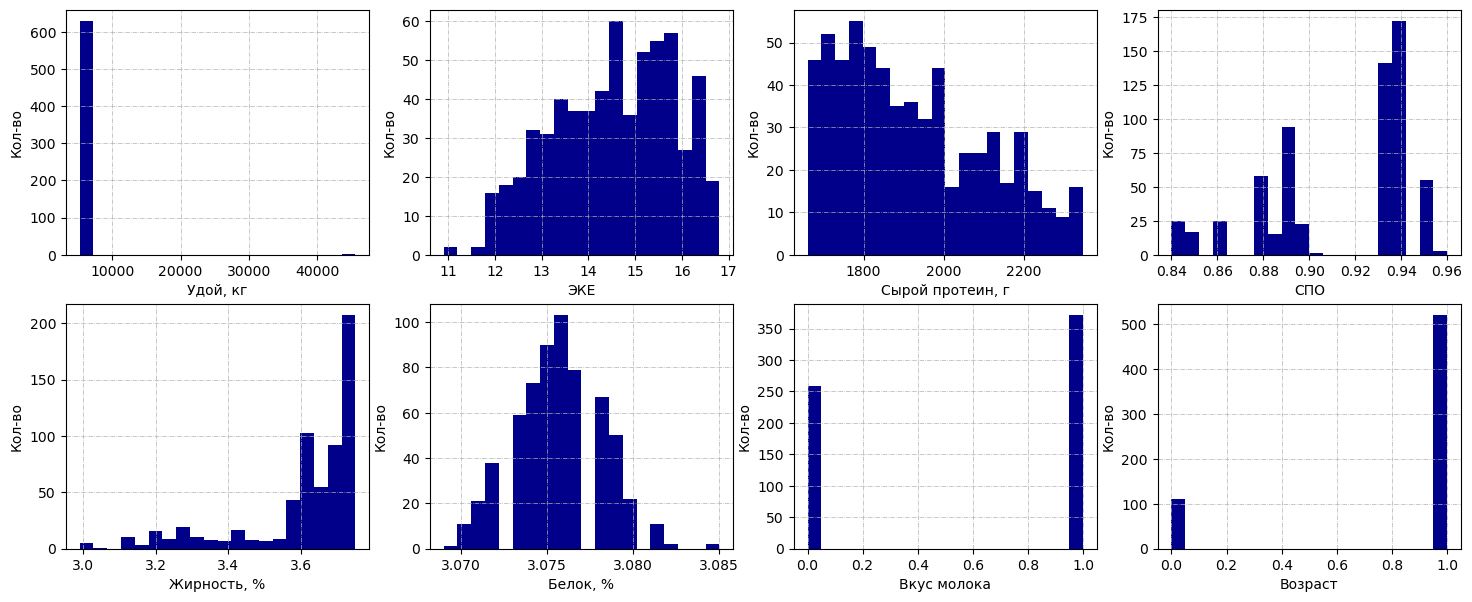


 Гистограммы параметров в датасете коров на покупку: 



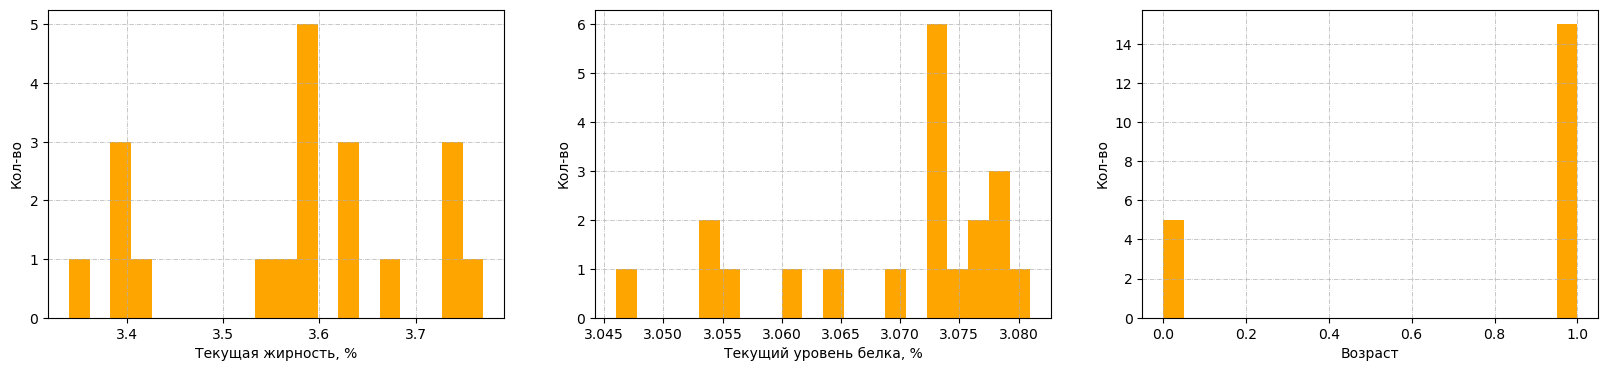

In [33]:
print(color.BOLD+'Гистограммы параметров в основном датасете: \n')
fig, axs = plt.subplots(2, 4, figsize=(18, 7))
cols = ['удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'жирность%', 'белок%', 'вкус_молока', 'возраст']
xcaptions = ['Удой, кг', 'ЭКЕ', 'Сырой протеин, г', 'СПО', 'Жирность, %', 'Белок, %', 'Вкус молока', 'Возраст']
for i in range (2):
    for feat in range(0, int(len(cols)/2)):    
        axs[i][feat].hist(data_f_full[cols[feat+4*i]], bins=20, color='DarkBlue')
        axs[i][feat].set_xlabel(xcaptions[feat+4*i])
        axs[i][feat].set_ylabel('Кол-во')
        axs[i][feat].grid(axis='both', linestyle='dashdot', linewidth=0.5)
plt.show()

print(color.BOLD+'\n Гистограммы параметров в датасете коров на покупку: \n')
fig, axs = plt.subplots(1, 3, figsize=(20, 4))
cols = ['текущая_жирность%', 'текущий_уровень_белок%', 'возраст']
xcaptions = ['Текущая жирность, %', 'Текущий уровень белка, %', 'Возраст']
for feat in range(0, (len(cols))):    
    axs[feat].hist(data_cow_buy[cols[feat]], bins=20, color='Orange')
    axs[feat].set_xlabel(xcaptions[feat])
    axs[feat].set_ylabel('Кол-во')
    axs[feat].grid(axis='both', linestyle='dashdot', linewidth=0.5)
plt.show()

<a id='outliers'> </a>
Подозрительно выглядит только гистограмма по удою в "главном" датасете - там есть явные выбросы, которые нужно удалить (при ближайшем рассмотрении выясняем, что такой выброс только один, он скрывается в строке 16).

In [35]:
data_f_full = data_f_full.drop(16).reset_index(drop=True)

## Корреляционный анализ
<a id='correlation'></a>

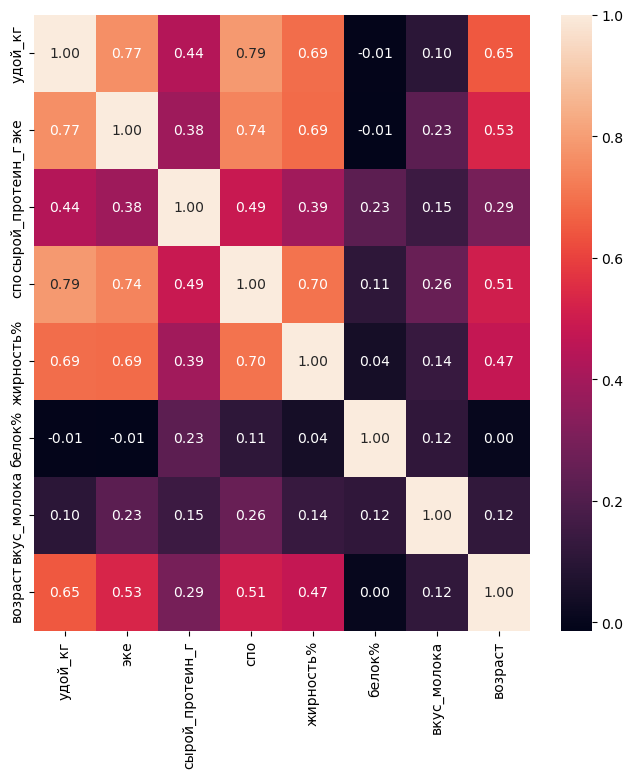

In [37]:
plt.figure(figsize=(8, 8))
sns.heatmap(data_f_full.drop('id', axis=1).corr(method='spearman', numeric_only=True), annot=True, fmt='.2f');

Видно, что удой лучше всего коррелирует с характеристиками корма. Между ЭКЕ (энергетическая кормовая единица), СПО (сахаро-протеиновое соотношение) и удоем наблюдается высокая прямо пропорциональная связь (коэффициент 0.7–0.9 по шкале Чеддока), между сырым протеином и удоем связь умеренная (коэффициент 0.3–0.5).<br>
По вкусовым характеристикам: есть лишь слабая (0.1–0.3) связь между вкусом и характеристиками корма.<br><br>
Следует отметить, что в рамках этого проекта мы не пытаемся выяснить "обычными" средствами анализа данных, как вкус и удой зависят от, например, породы коров, но лишь подготавливаем данные для машинного обучения и обучаем модель делать предсказание по совокупности признаков.


 Тепловая карта корреляций параметров по невкусному молоку: 



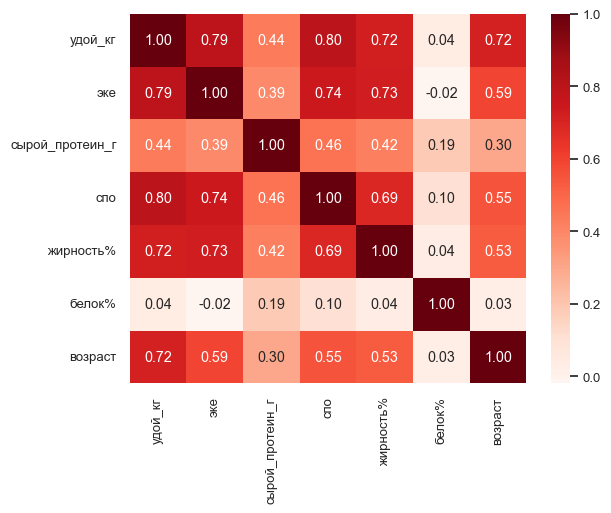


 Тепловая карта корреляций параметров по вкусному молоку: 



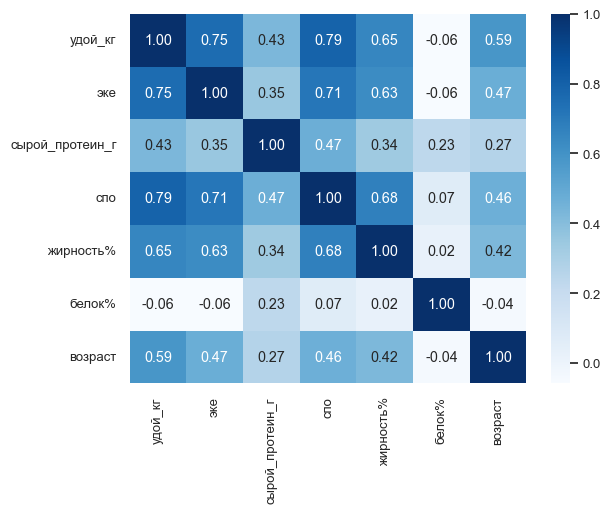

In [39]:
sns.set(font_scale=0.86)
print(color.BOLD+'\n Тепловая карта корреляций параметров по невкусному молоку: \n')
sns.heatmap(data_f_full[data_f_full['вкус_молока'] == 0].drop(['id','вкус_молока'], axis=1).corr(method='spearman', numeric_only=True), \
            annot=True, cmap='Reds', fmt='.2f');
plt.show()

print(color.BOLD+'\n Тепловая карта корреляций параметров по вкусному молоку: \n')
sns.heatmap(data_f_full[data_f_full['вкус_молока'] == 1].drop(['id','вкус_молока'], axis=1).corr(method='spearman', numeric_only=True), \
            annot=True, cmap='Blues', fmt='.2f');
plt.show()

#### Графики зависимости удоя от количественных признаков 
<a id='yield_cat_charts'></a>

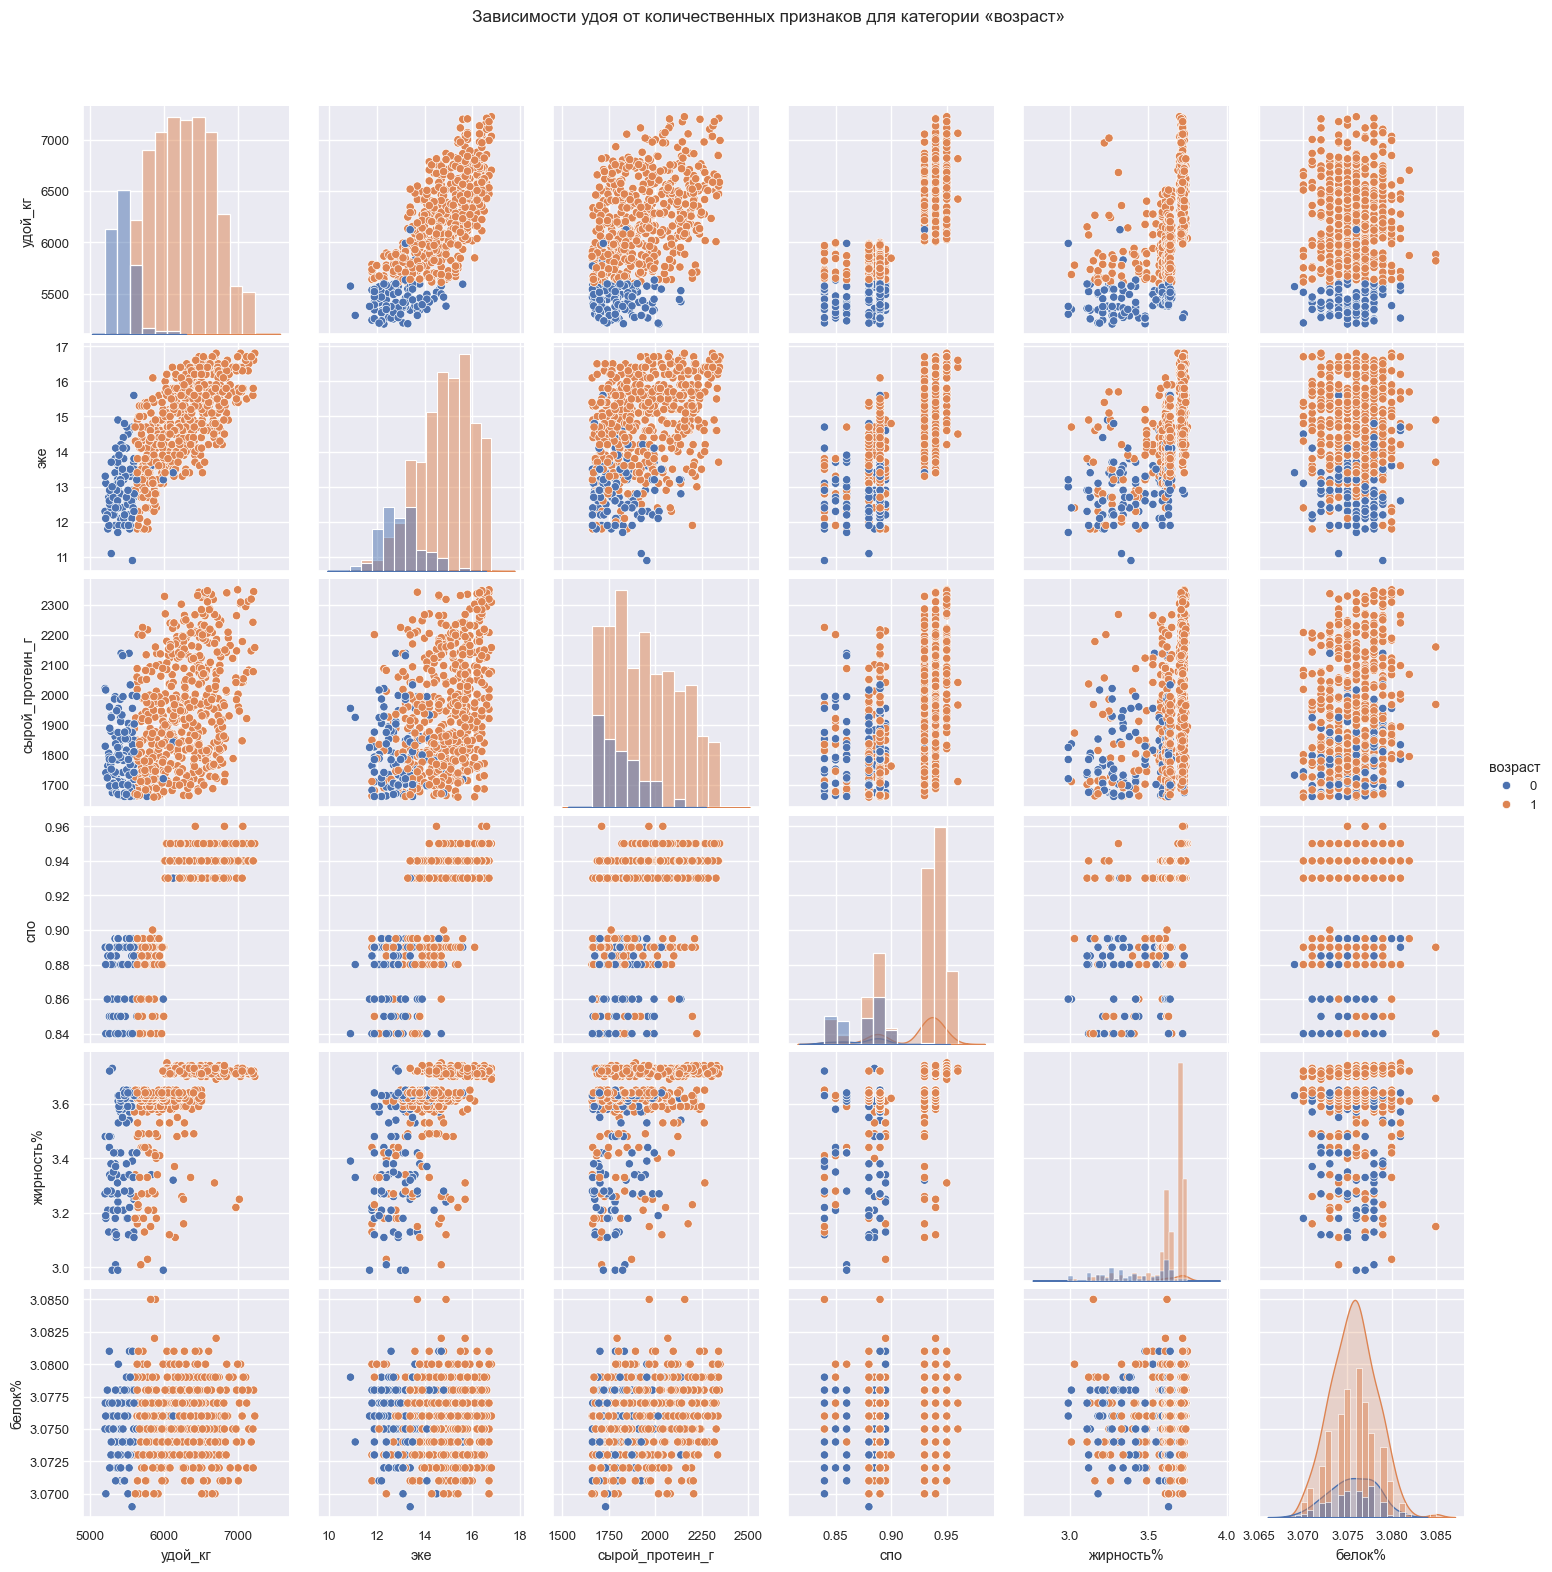

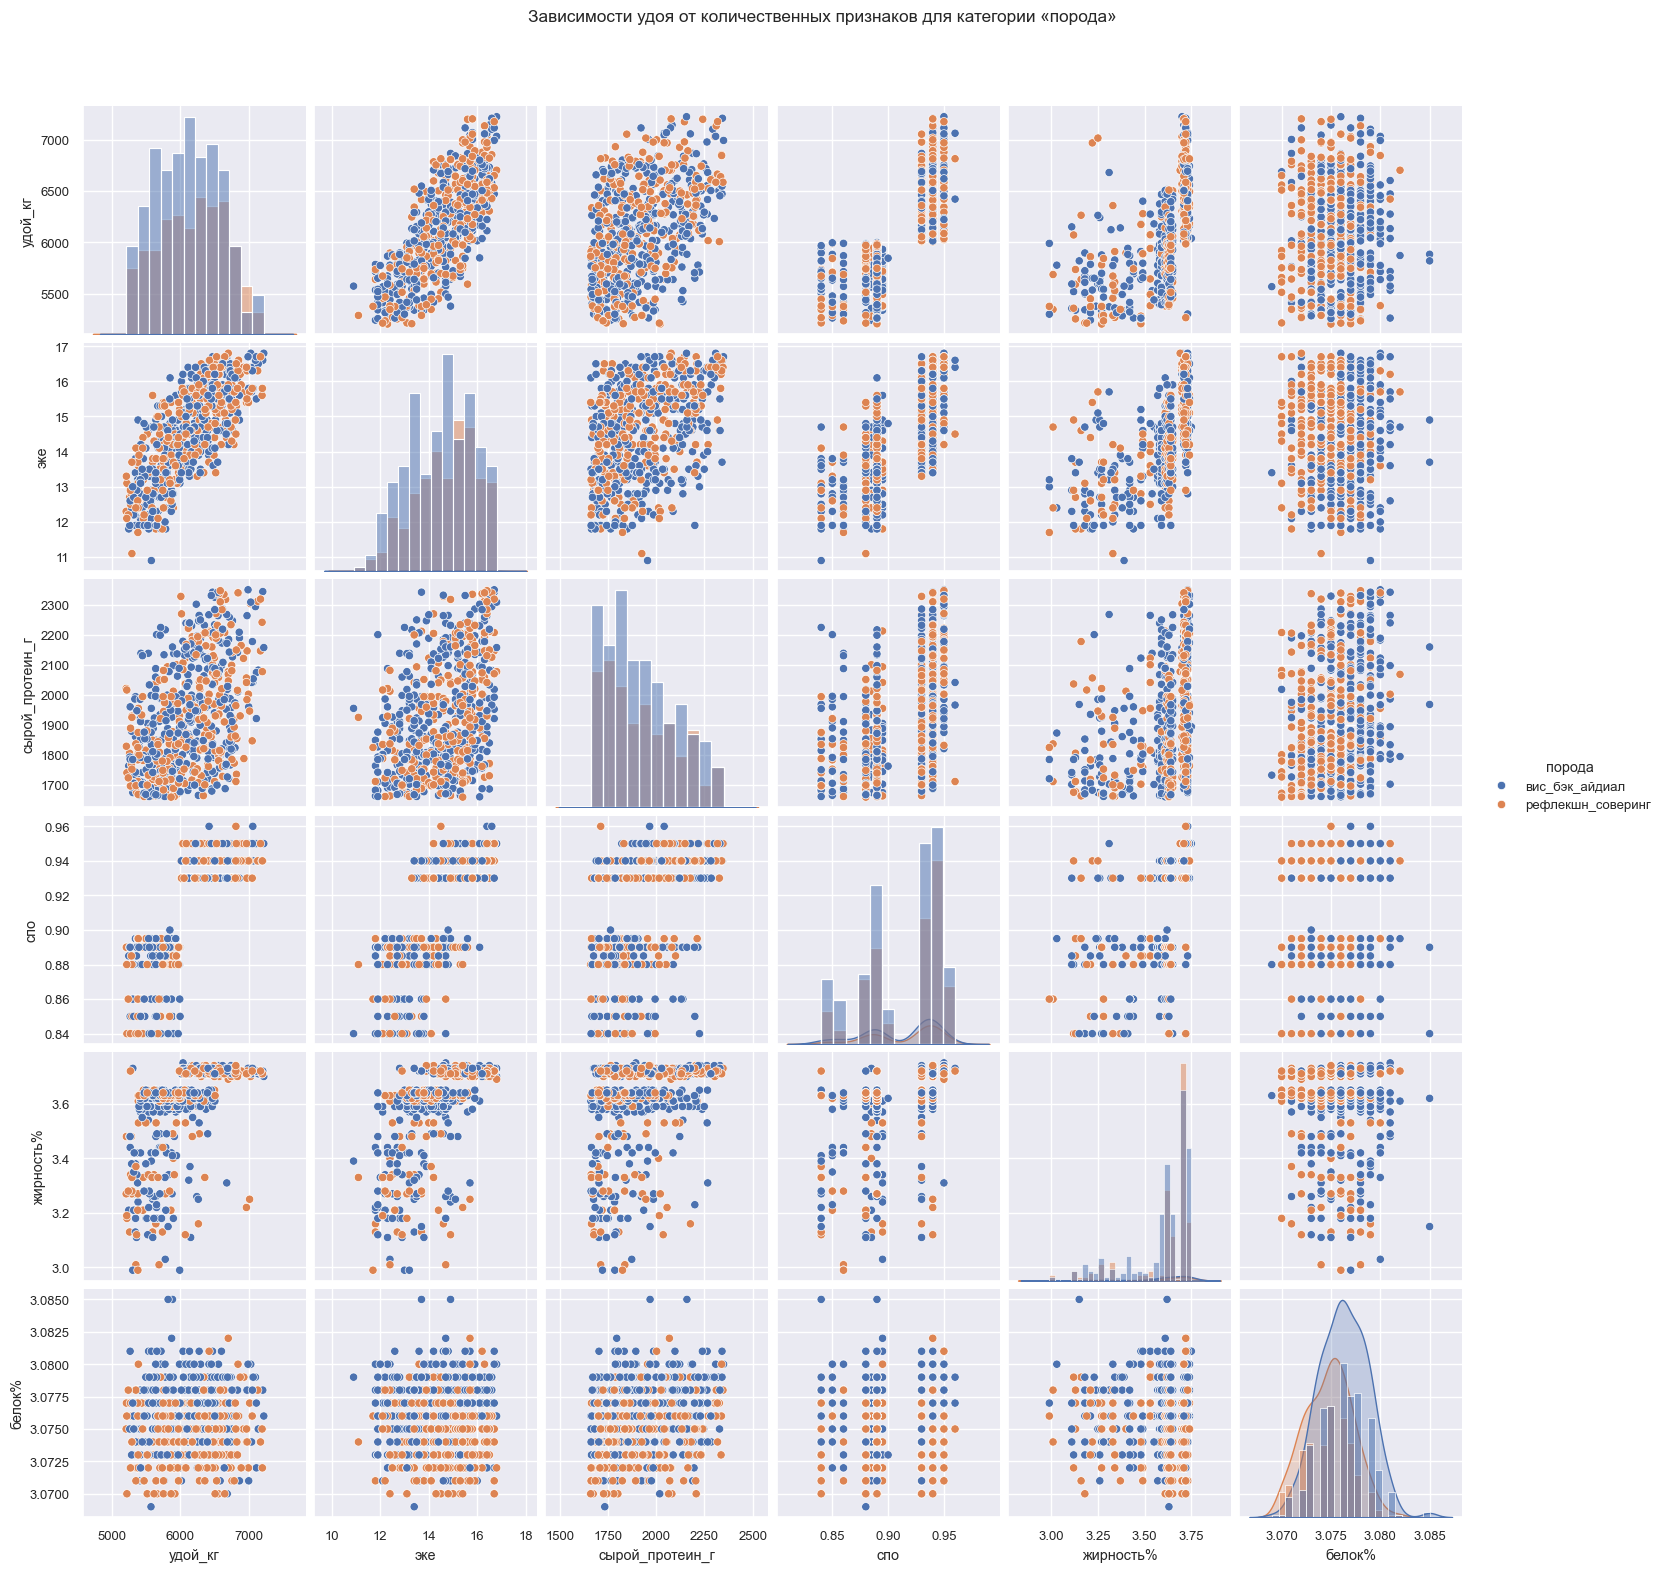

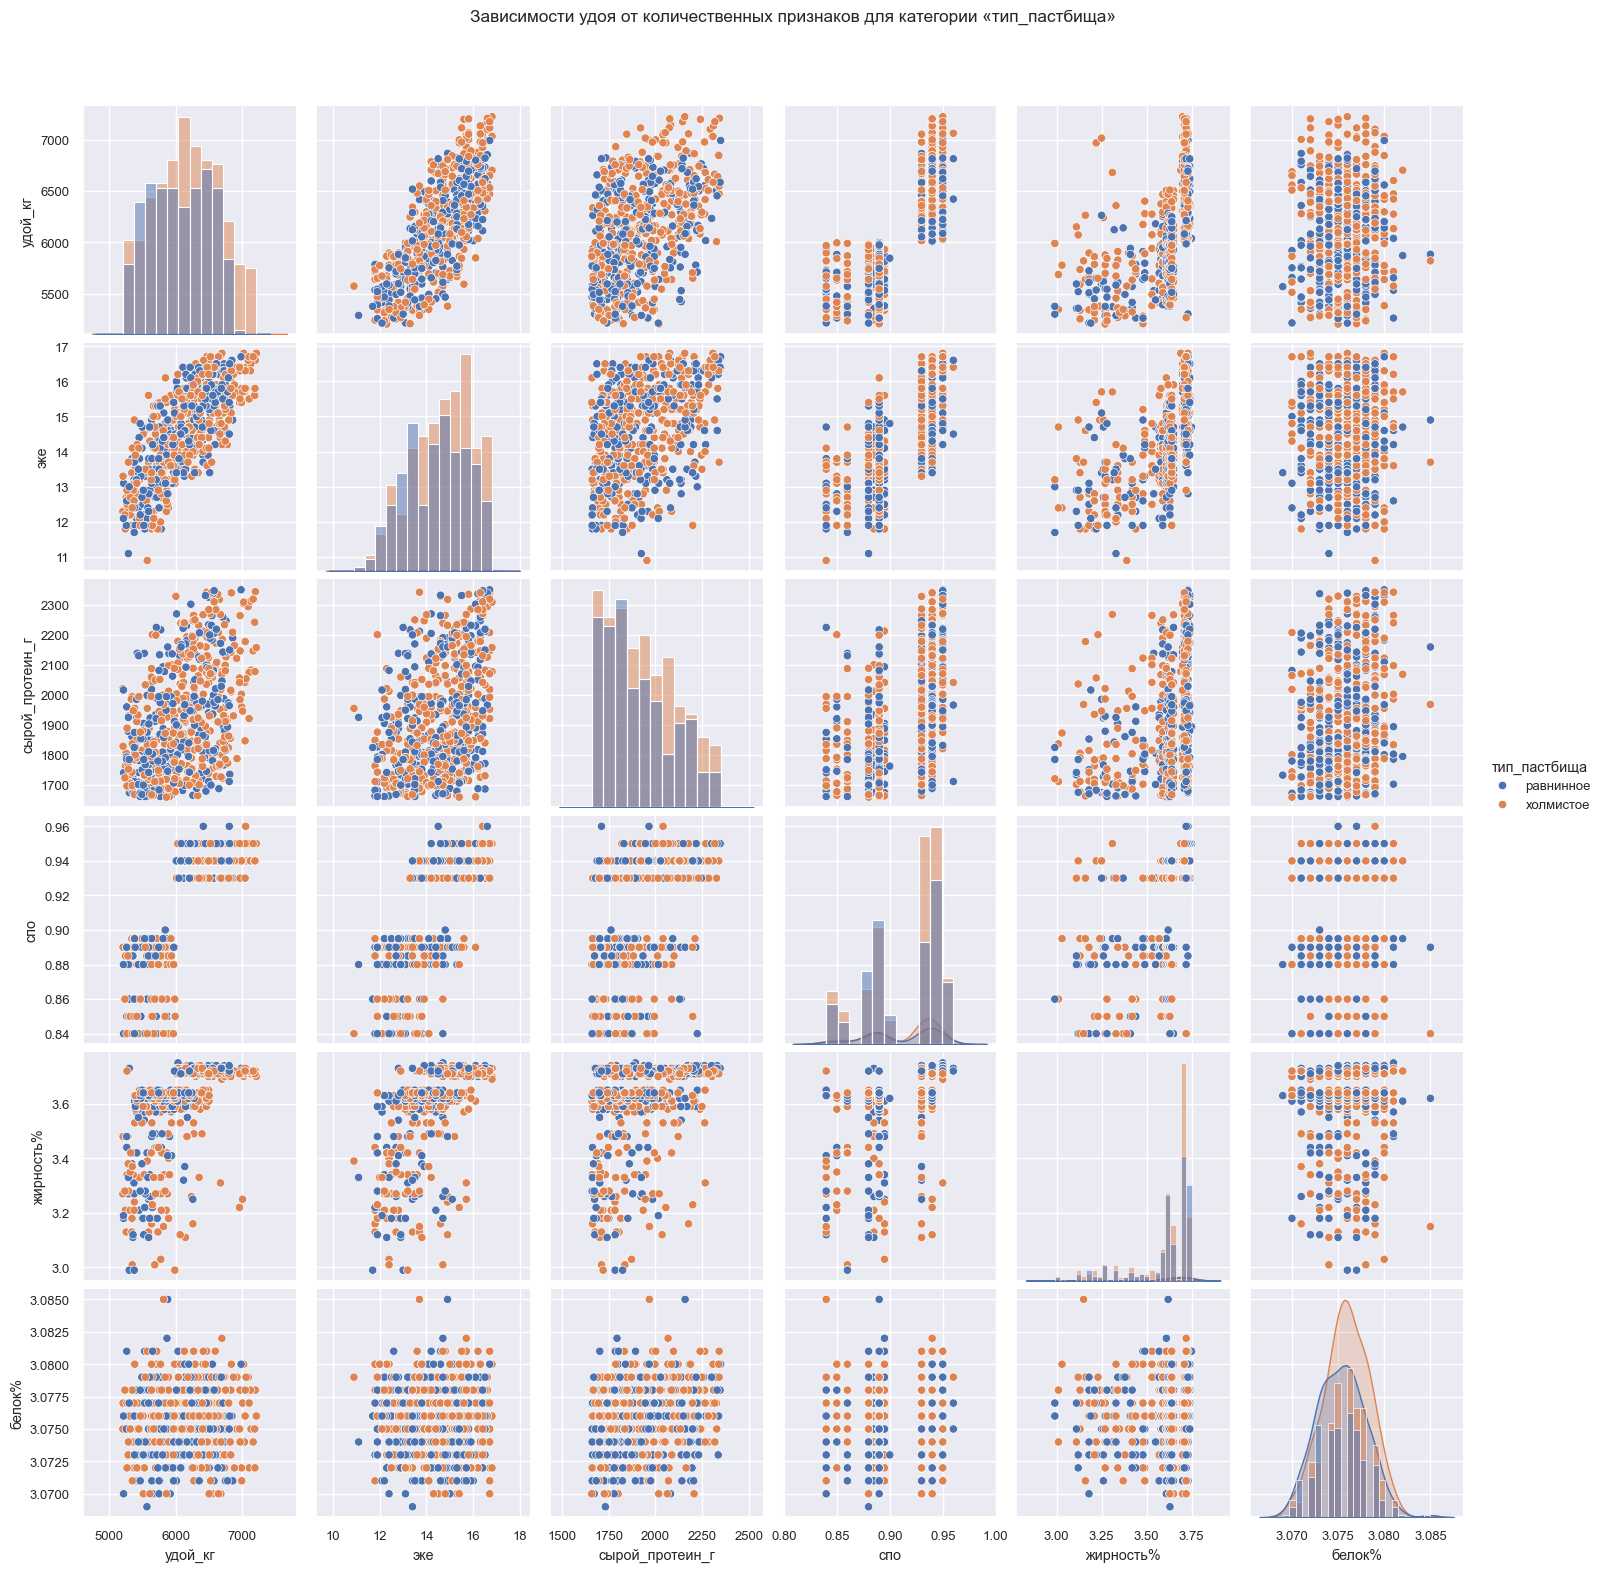

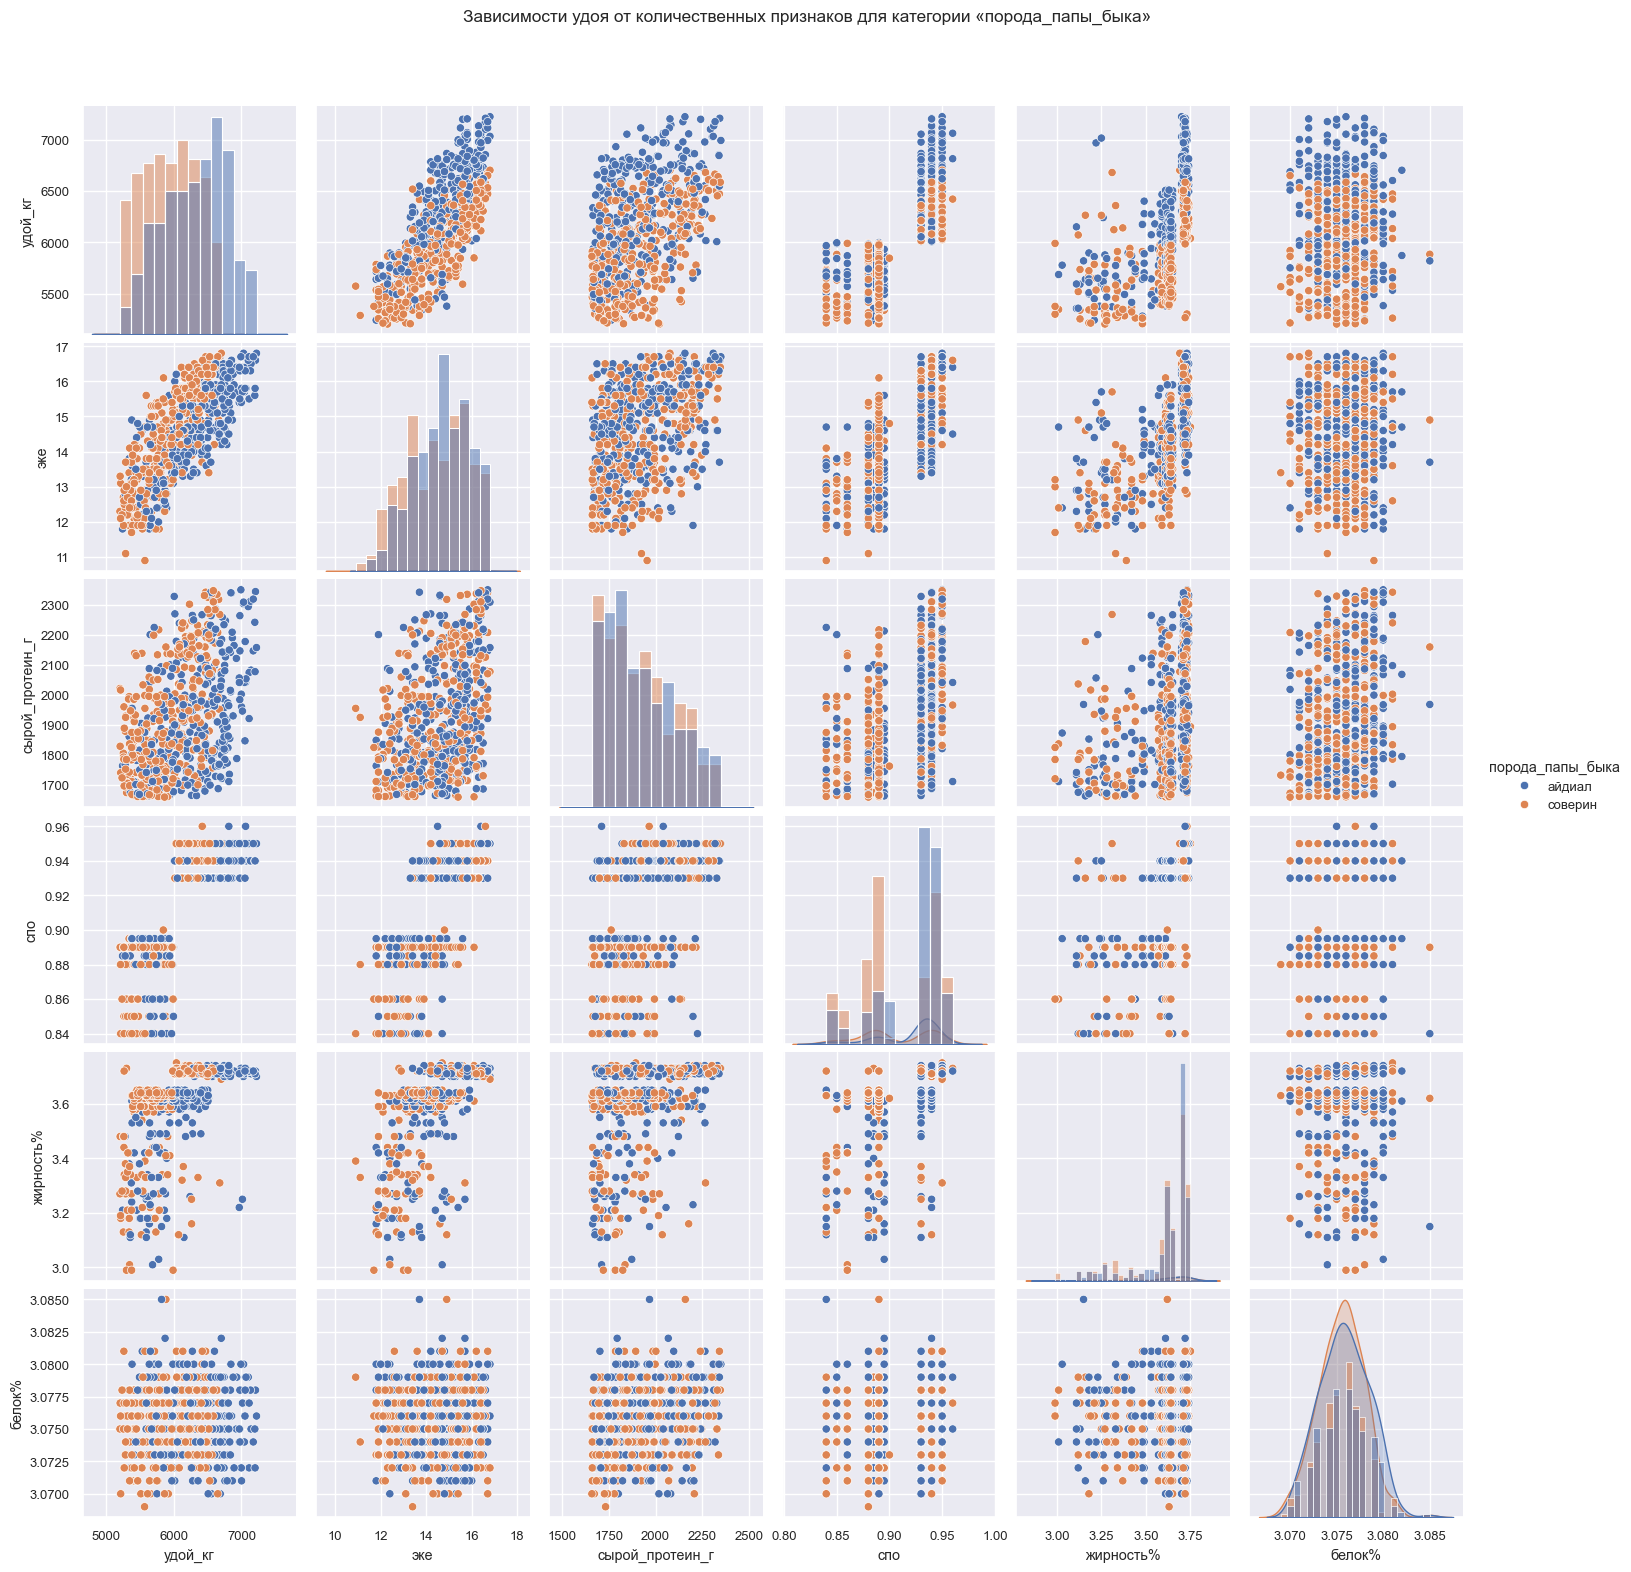

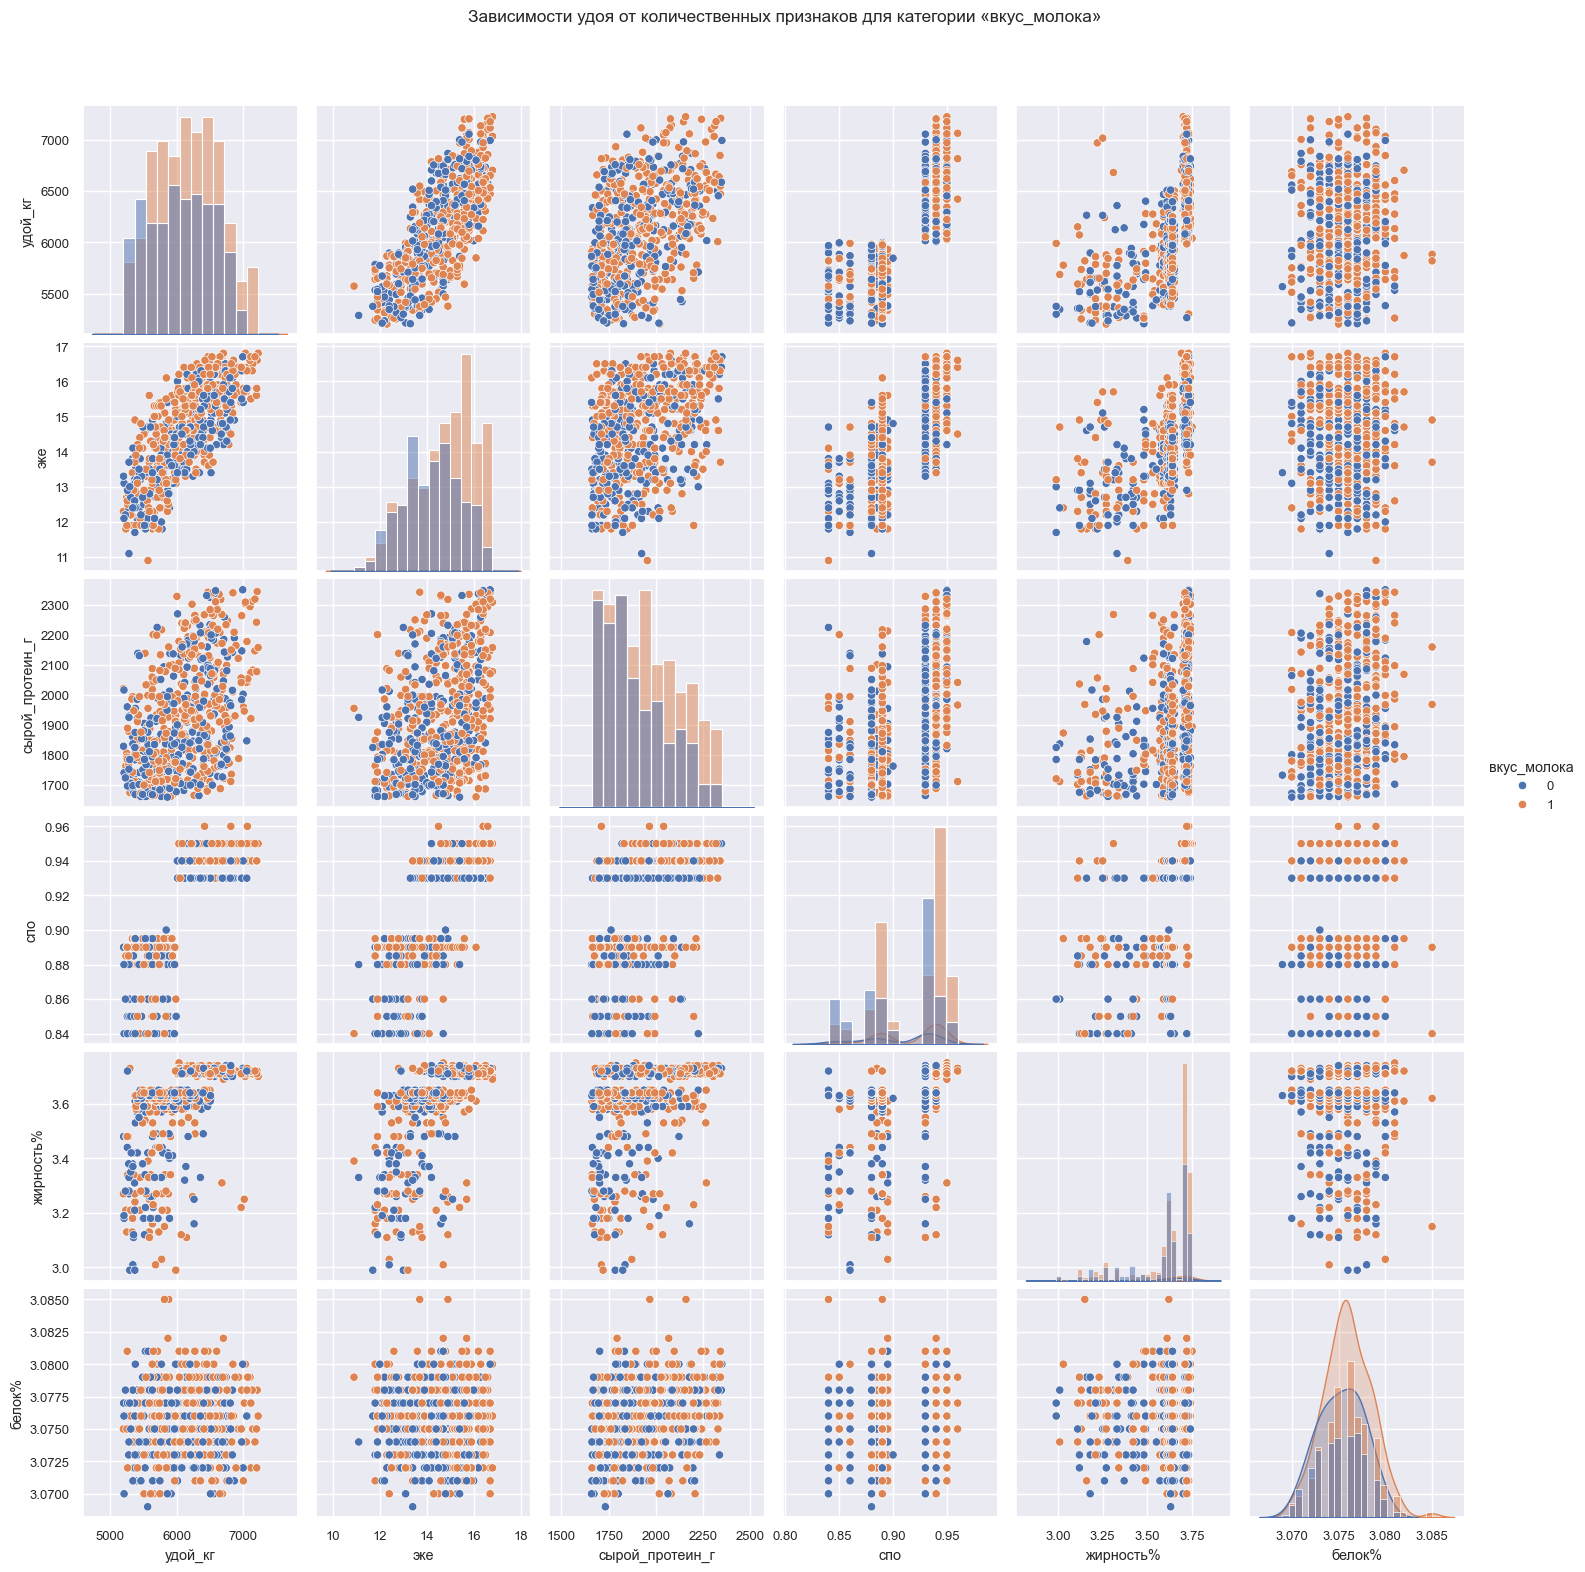

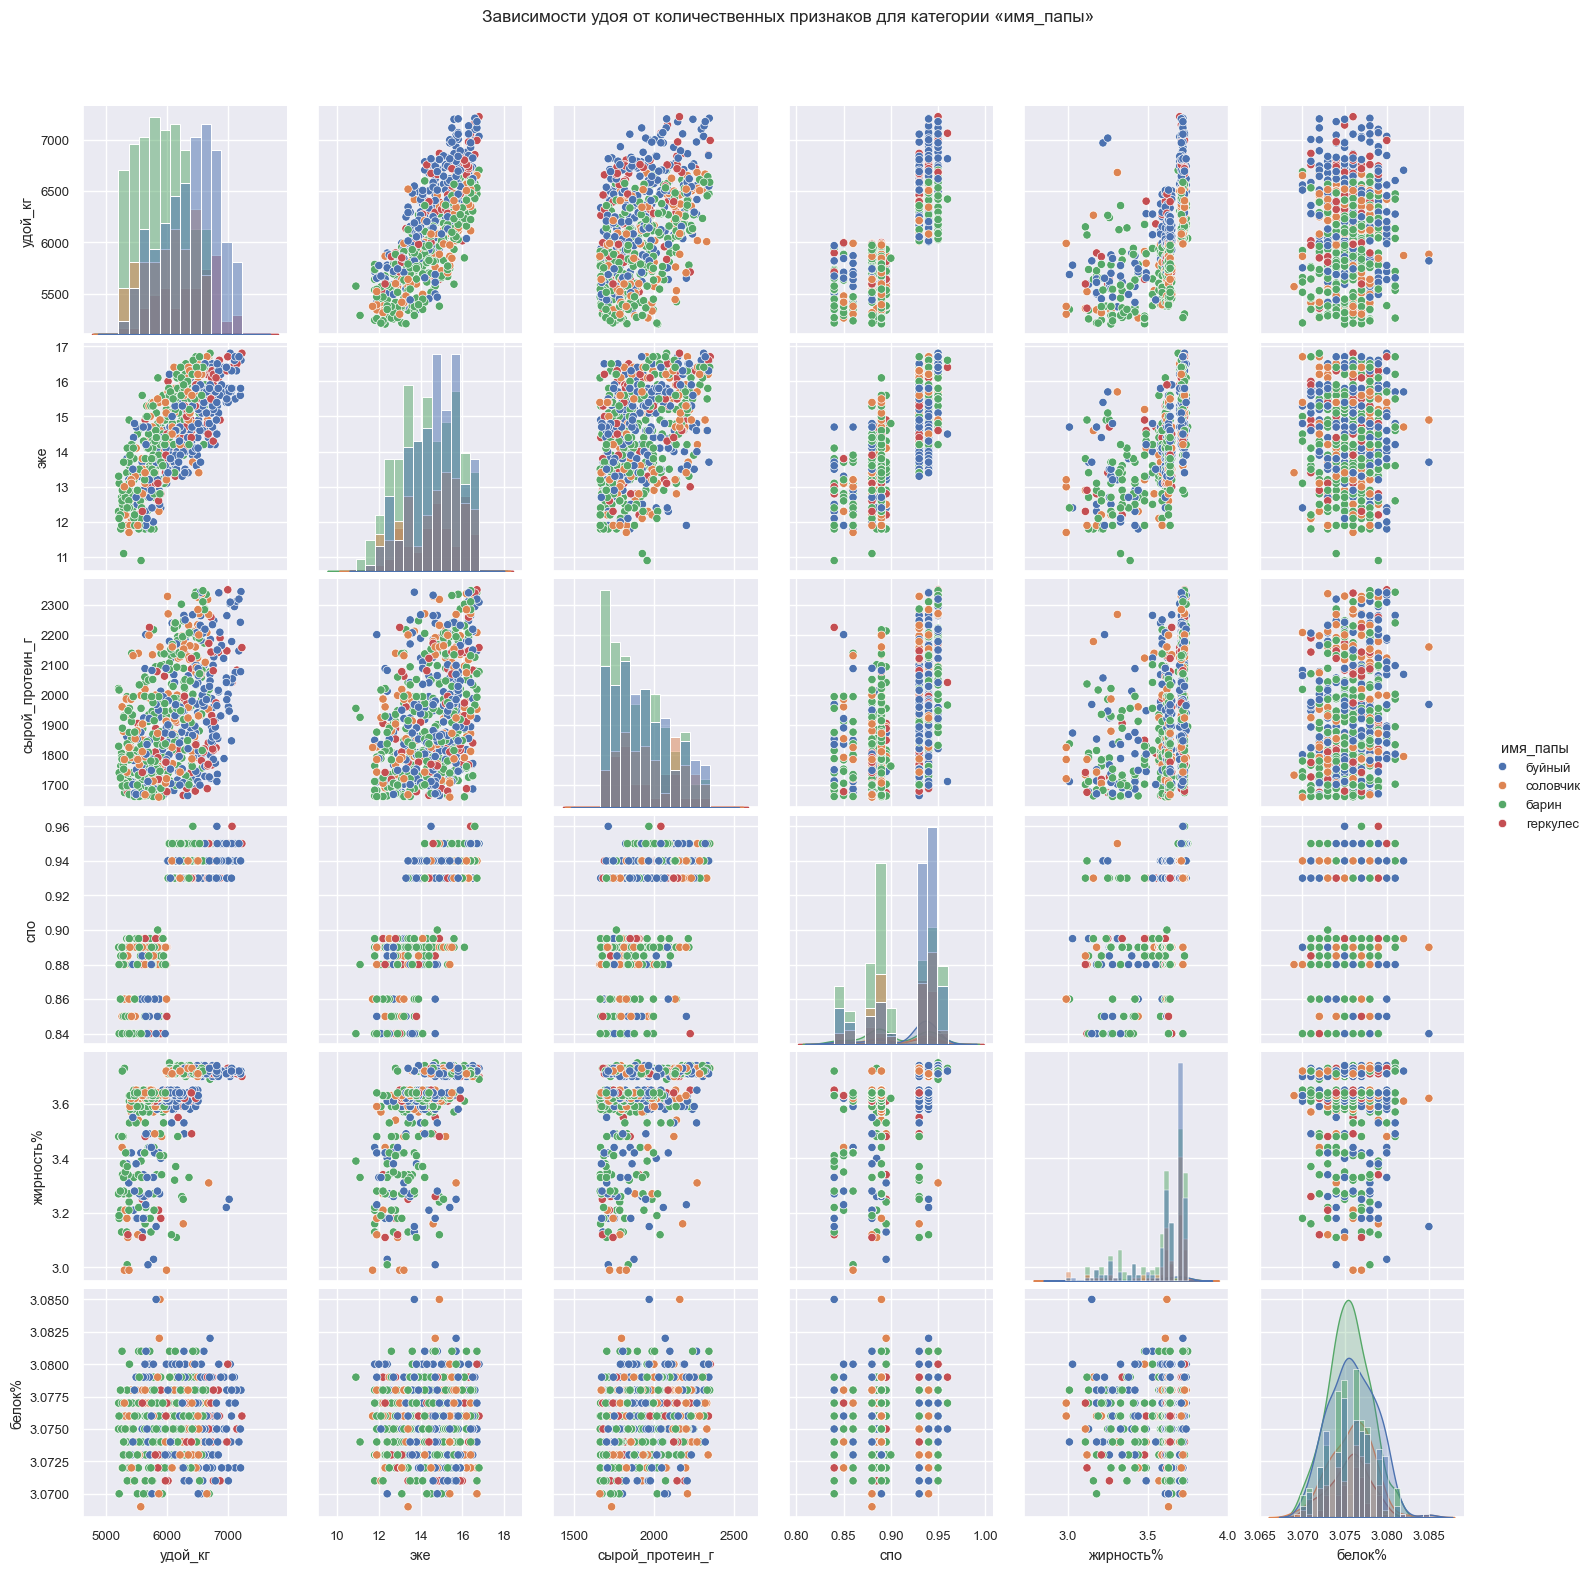

In [41]:
num_data_names = ['удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'жирность%', 'белок%']
cat_data_names = ['возраст', 'порода', 'тип_пастбища', 'порода_папы_быка', 'вкус_молока', 'имя_папы']

for category in cat_data_names:    
    tmp_name = num_data_names.copy()
    tmp_name.append(category)
    a = sns.pairplot(data_f_full[tmp_name], hue=category)
    a.map_diag(sns.histplot)
    a.fig.suptitle('Зависимости удоя от количественных признаков для категории «' + category + '»', y=1.05)

Из интересного - отметим, что корм по СПО чётко делится на три группы, и зависимость удоя от СПО оказывается нелинейной. Можно попробовать ввести категорию из этих трёх групп как отдельную фичу (от англ. feature, входной признак).

## Обучение модели линейной регрессии

Для начала определимся со входными признаками, по которым мы будем обучать модель. Все ли показатели нужны для обучения?

In [45]:
display(data_cow_buy[:4])
display(data_f_full[:4])

порода тип_пастбища порода_папы_быка  имя_папы  \
0     вис_бэк_айдиал    холмистое           айдиал  геркулес   
1     вис_бэк_айдиал    равнинное          соверин    буйный   
2  рефлекшн_соверинг    равнинное          соверин     барин   
3  рефлекшн_соверинг    холмистое           айдиал    буйный   

   текущая_жирность%  текущий_уровень_белок%  возраст  
0               3.58                   3.076        1  
1               3.54                   3.081        0  
2               3.59                   3.074        1  
3               3.40                   3.061        1

id  удой_кг   эке  сырой_протеин_г    спо             порода тип_пастбища  \
0   1     5863  14.2             1743  0.890     вис_бэк_айдиал    равнинное   
1   2     5529  12.8             2138  0.890     вис_бэк_айдиал    равнинное   
2   3     5810  14.0             1854  0.885  рефлекшн_соверинг    холмистое   
3   4     5895  12.4             2012  0.885  рефлекшн_соверинг    холмистое   

  порода_папы_быка  жирность%  белок%  вкус_молока  возраст  имя_папы  
0           айдиал       3.58   3.076            1        1    буйный  
1          соверин       3.54   3.079            1        0  соловчик  
2          соверин       3.59   3.074            0        1     барин  
3           айдиал       3.40   3.075            0        1    буйный

Судя по именам быков, в стаде фермера коровы от этих же "производителей" Экофермы, и имена папы быка мы выбрасывать из данных для обучения не будем. И порода папы быка влияет на средний удой, её исключать нельзя - легко убедиться:

In [47]:
print(color.BOLD+'⇓ Средний удой породы в зависимости от породы предка, кг ⇓')
display(data_f_full.groupby(['порода', 'порода_папы_быка'])['удой_кг'].mean())

⇓ Средний удой породы в зависимости от породы предка, кг ⇓


порода             порода_папы_быка
вис_бэк_айдиал     айдиал              6264.110553
                   соверин             5909.947977
рефлекшн_соверинг  айдиал              6389.805085
                   соверин             5971.971014
Name: удой_кг, dtype: float64

<b>Исключим следующие признаки:</b>

1) Зависимость удоя от сырого протеина нелинейна, этот показатель уберём;
<br><b>NB</b><i> По факту в дальнейшем не убрали, но даже добавили новый признак на его основе

3) Столбец с порядковым номером (id) нам тоже не нужен;

4) Вкус - в данном случае предсказывать будем удой. Вкус, по сути, характеристика самого удоя, а не фактор, приведший к удою.<br><b>NB</b><i> на самом деле мы пробовали оставлять и этот параметр, и, более того, с ним получили лучшие результаты - но его нельзя использовать для обучения, так как в данных, по которым нам нужно спрогнозировать удой, вкуса молока нет.</i>

<b>Вынесем данные для обучения и целевые показатели в датафреймы X и y</b>; убедимся, что всё в порядке с размерностями. Затем выделим выборки для обучения и для теста обученной модели.

In [50]:
# a key line for experimenting on features selection
learning_data = data_f_full.drop(['id', 'имя_папы', 'вкус_молока', 'жирность%', 'белок%'], axis=1)

# FEATURES to delete FOR TECH TASK #3
#learning_data = data_f_full.drop(['id', 'вкус_молока', 'жирность%', 'белок%'], axis=1)

# let's put features in X
X = learning_data.drop('удой_кг', axis=1)

# let's put targets in y
y = learning_data['удой_кг']

#display(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE)

In [51]:
# firstly let's transform categorical data to numbers
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# we don't need to categorize 'возраст', but it's just simpler this way
#cat_names = ['порода', 'тип_пастбища', 'возраст', 'имя_папы', 'порода_папы_быка']

#FOR TECH TASK #1
cat_names = ['порода', 'тип_пастбища', 'возраст', 'порода_папы_быка']

X_train_encoded = cat_encoder.fit_transform(X_train[cat_names])
X_test_encoded = cat_encoder.transform(X_test[cat_names])

cat_df_train = pd.DataFrame(X_train_encoded, columns=cat_encoder.get_feature_names_out())
cat_df_test = pd.DataFrame(X_test_encoded, columns=cat_encoder.get_feature_names_out())

# second, some data scaling for the ease of the model
scaler = StandardScaler()

names = X_train.columns
num_names = [n for n in names if n not in cat_names] #a trick to "subtract" lists

X_train_scaled = scaler.fit_transform(X_train[num_names])
X_test_scaled = scaler.transform(X_test[num_names])
scaled_df_train = pd.DataFrame(X_train_scaled, columns=num_names)
scaled_df_test = pd.DataFrame(X_test_scaled, columns=num_names)

X_train_ready = scaled_df_train.join(cat_df_train)
X_test_ready = scaled_df_test.join(cat_df_train)

Лишний раз убедимся, что всё в порядке. Датафрейм со входными признаками (всего 8 признаков) из 628 значений разбили на тренировочную часть из 471 значения (75%) и тестовую часть из 157 значений (25%).<br>
Количество входных признаков после кодирования категориальных параметров больше не стало, т. к. все эти параметры состояли из двух значений, а мы указали <code>drop='first'</code>

In [53]:
print(X.shape)
print(X_train.shape, X_train_ready.shape)
print(X_test.shape, X_test_ready.shape)
display(X_train_ready[:3])

(628, 7)
(471, 7) (471, 7)
(157, 7) (157, 7)


эке  сырой_протеин_г       спо  порода_рефлекшн_соверинг  \
0  0.986861        -0.074152  0.849982                       0.0   
1  0.297797         2.109710  1.156756                       1.0   
2 -0.927204        -0.528222 -0.683893                       1.0   

   тип_пастбища_холмистое  возраст_1  порода_папы_быка_соверин  
0                     1.0        1.0                       1.0  
1                     1.0        1.0                       1.0  
2                     1.0        0.0                       1.0

#### Обучение модели, вариант 1

Всё в порядке, и наконец-то можно обучить модель и рассчитать метрики её качества.

In [56]:
model_lr = LinearRegression()
model_lr.fit(X_train_ready, y_train)
predictions = model_lr.predict(X_test_ready)

r2 = r2_score(y_test, predictions)

print('Вариант: 17')
print(f'Метрика r2 = {r2:.3f}')
rmse = root_mean_squared_error(y_test, predictions)
print(f'Метрика RMSE = {rmse:.1f}')
mse = mean_squared_error(y_test, predictions)
print(f'Метрика MSE = {mse:.1f}')
mae = mean_absolute_error(y_test, predictions)
print(f'Метрика MAE = {mae:.1f}')

Вариант: 17
Метрика r2 = 0.568
Метрика RMSE = 327.9
Метрика MSE = 107551.2
Метрика MAE = 263.9


<b>Результаты первого прогона выглядели приблизительно так:</b><br>
Метрика r2 = 0.551<br>
Метрика RMSE = 334.5

>Результаты работы модели, прямо скажем, <b>плохие</b>. Попробуем изменить набор фич для обучения.
<br>Мы выбрасывали показатели <code>'сырой_протеин_г'</code>, <code>'id'</code>, <code>'вкус_молока'</code>. Оставим первый из них.<br><br>
<i>В итоге:</i> показатель r2 увеличился на тысячные доли, а RMSE уменьшилась на 3 единицы. Лучше не стало, показатели были исключены корректно. Нужно пробовать другие подходы.

После нескольких попыток отбрасывания из обучающего набора как логичных (для выброса) параметров, так и просто случайно выбранных, пришли к интересному результату:
><b>метрики получаются лучше всего, если удалить только номер сэмпла <code>id</code>, породу <code>порода_папы_быка</code> и имя папы быка <code>имя_папы</code>.</b>

Однако, мы также удалили показатель <code>вкус_молока</code> - мы не сможем предсказывать удой, в данных для предсказания нет этого показателя.
<br><br>С показателем <code>вкус_молока</code>:<br>
Метрика r2 = 0.614<br>
Метрика RMSE = 310.0<br><br>
Итоговые метрики выбранной модели:<br>
Метрика r2 = 0.595<br>
Метрика RMSE = 317.6<br>
Метрика MSE = 100842.4<br>
Метрика MAE = 260.1<br>

#### Анализ остатков для модели № 1

Проведём анализ остатков - не прояснит ли он что-нибудь?

⇓ Стат. данные по остаткам ⇓


count    157.000000
mean      37.197408
std      326.876265
min     -616.762658
25%     -197.966890
50%       27.464868
75%      266.116905
max      813.751722
Name: удой_кг, dtype: float64

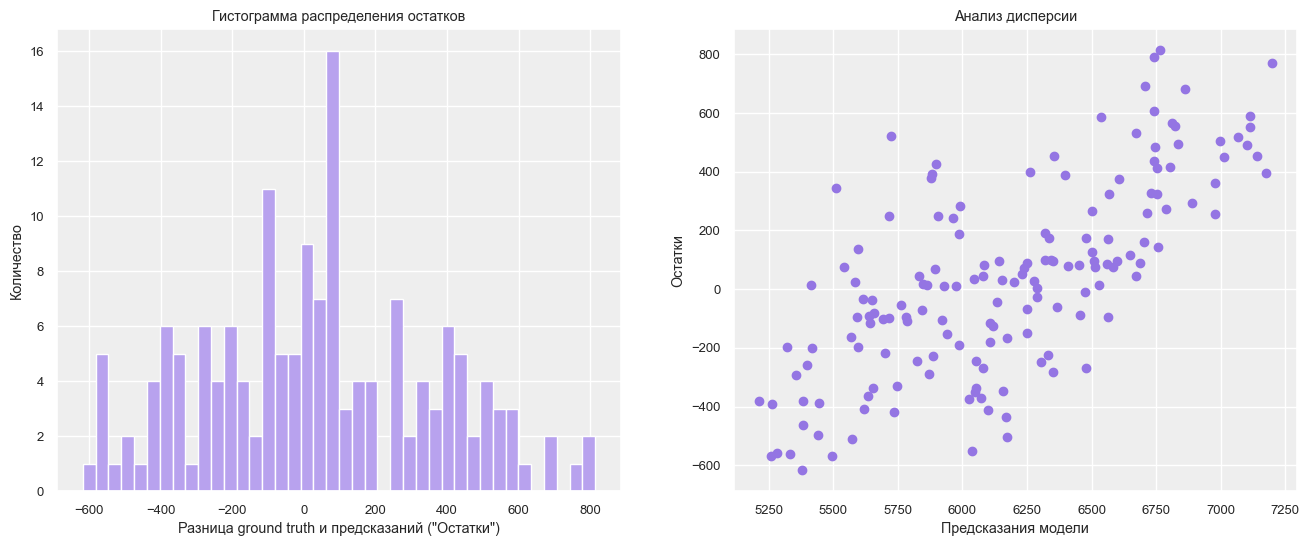

In [62]:
residuals = y_test - predictions
print(color.BOLD+'⇓ Стат. данные по остаткам ⇓')
display(residuals.describe())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(residuals, bins=40, color='#b8a2ee')
axs[0].set_facecolor("#eeeeee")
axs[0].set_title('Гистограмма распределения остатков')
axs[0].set_xlabel('Разница ground truth и предсказаний (\"Остатки\")')
axs[0].set_ylabel('Количество')

axs[1].scatter(y=residuals, x=y_test, color='#9475e3')
axs[1].set_facecolor("#eeeeee")
axs[1].set_title('Анализ дисперсии')
axs[1].set_ylabel('Остатки')
axs[1].set_xlabel('Предсказания модели')
plt.show()

>По гистограмме кажется, что <i>в целом</i> модель ошибается равномерно в обе стороны. Но если быть совсем точным, то есть небольшой перекос в плюс, его видно по вычисленному значению среднего = +27, т. е. модель предсказывает слегка меньшие значения, чем реальный удой.<br>
Также возможно, что распределение не совсем нормальное - на гистограмме можно углядеть разные моды, если захотеть, а ещё поиграть с разбиением по корзинам. Может быть, просто не хватает данных.<br><br>
Однако, всё это подсказывает нам, что можно попробовать способы, работающие при "неидеальном" распределении остатков: добавить дополнительные признаки и\или трансформировать данные.

> По графику анализа дисперсии видим, что модель ошибается неравномерно => качество её не очень хорошее

### Вторая модель линейной регрессии

#### Изменения во второй модели

- Во-первых, разобьём показатель СПО (сахаро-протеиновое_соотношение) на три подтипа (мы уже заметили, что они чётко проступают на графиках).

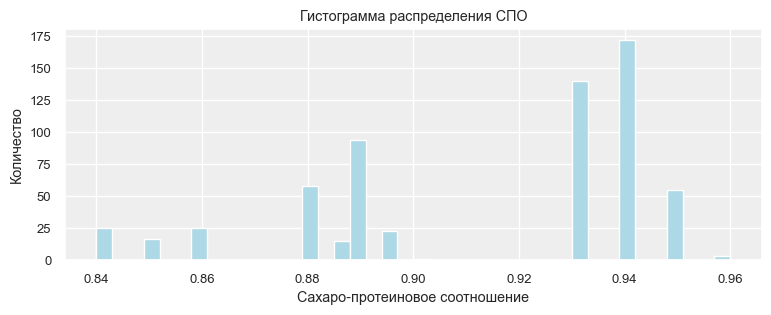

In [68]:
fig, axs = plt.subplots(1, 1, figsize=(9, 3))
axs.hist(X['спо'], bins=40, color='LightBlue')
axs.set_facecolor("#eeeeee")
axs.set_title('Гистограмма распределения СПО')
axs.set_xlabel('Cахаро-протеиновое соотношение')
axs.set_ylabel('Количество')
plt.show()

Определим:
<br>
СПО 1 типа = до 0.87 (не включительно)<br>
СПО 2 типа = 0.87 - 0.91<br>
СПО 3 типа = от 0.91 (не включительно)<br>

In [70]:
def spo_type(spo):
    if spo < 0.87:
        return "спо_1"
    else:
        if spo > 0.91:
            return "спо_3"
    return "спо_2"

""" a hint from Tech Requirements doesn't help either
def spo_type(spo):
    if spo > 0.91:
        return "спо_2"    
    return "спо_1"
"""

X['тип_спо'] = X['спо'].apply(spo_type)

Таким образом, мы ввели новую категориальную фичу - "тип СПО";

- Во-вторых, (по подсказке в ТЗ) трансформируем показатель ЭКЕ - возведём его в квадрат, получив новую фичу "ЭКЕ в квадрате"

In [73]:
X['эке'] = np.power(X['эке'], 2)
X = X.rename(columns={'эке':'эке_квадрат'})
display(X[:3])

эке_квадрат  сырой_протеин_г    спо             порода тип_пастбища  \
0   201.639999             1743  0.890     вис_бэк_айдиал    равнинное   
1   163.840012             2138  0.890     вис_бэк_айдиал    равнинное   
2   196.000000             1854  0.885  рефлекшн_соверинг    холмистое   

  порода_папы_быка  возраст тип_спо  
0           айдиал        1   спо_2  
1          соверин        0   спо_2  
2          соверин        1   спо_2

#### Подготовка данных для обучения модели № 2

Пройдём те же шаги (что и для первой модели) по подготовке данных непосредственно для обучения.

In [76]:
#X = X.drop('спо', axis=1) #it's decision from later steps

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

In [77]:
# == Transforming (encoding) categorical data ==
cat_encoder_1 = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
cat_names.append('тип_спо') # need to add new categorical features

X_train_encoded = cat_encoder_1.fit_transform(X_train[cat_names])
X_test_encoded = cat_encoder_1.transform(X_test[cat_names])
cat_df_train = pd.DataFrame(X_train_encoded, columns=cat_encoder_1.get_feature_names_out())
cat_df_test = pd.DataFrame(X_test_encoded, columns=cat_encoder_1.get_feature_names_out())

# == Scaling numerical data ==
scaler_1 = StandardScaler()
names = X_train.columns
num_names = [n for n in names if n not in cat_names]
X_train_scaled = scaler_1.fit_transform(X_train[num_names])
X_test_scaled = scaler_1.transform(X_test[num_names])
scaled_df_train = pd.DataFrame(X_train_scaled, columns=num_names)
scaled_df_test = pd.DataFrame(X_test_scaled, columns=num_names)

# == Combining encoded and scaled DFs ==
X_train_ready = scaled_df_train.join(cat_df_train)
X_test_ready = scaled_df_test.join(cat_df_train)

In [78]:
# is it all ok?
print(X.shape)
print(X_train.shape, X_train_ready.shape)
print(X_test.shape, X_test_ready.shape)
display(X_train_ready[:3])
display(X_test_ready[:3])

(628, 8)
(471, 8) (471, 9)
(157, 8) (157, 9)


эке_квадрат  сырой_протеин_г       спо  порода_рефлекшн_соверинг  \
0     0.996206        -0.074152  0.849982                       0.0   
1     0.259525         2.109710  1.156756                       1.0   
2    -0.943481        -0.528222 -0.683893                       1.0   

   тип_пастбища_холмистое  возраст_1  порода_папы_быка_соверин  тип_спо_спо_2  \
0                     1.0        1.0                       1.0            0.0   
1                     1.0        1.0                       1.0            0.0   
2                     1.0        0.0                       1.0            1.0   

   тип_спо_спо_3  
0            1.0  
1            1.0  
2            0.0

эке_квадрат  сырой_протеин_г       спо  порода_рефлекшн_соверинг  \
0    -0.582206        -0.420110 -0.990668                       0.0   
1    -1.493792        -1.036348 -1.604217                       1.0   
2     0.828767         1.488066  1.156756                       1.0   

   тип_пастбища_холмистое  возраст_1  порода_папы_быка_соверин  тип_спо_спо_2  \
0                     1.0        1.0                       1.0            0.0   
1                     1.0        1.0                       1.0            0.0   
2                     1.0        0.0                       1.0            1.0   

   тип_спо_спо_3  
0            1.0  
1            1.0  
2            0.0

#### Обучение модели, вариант № 2

In [80]:
model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_ready, y_train)
predictions = model_lr_1.predict(X_test_ready)

r2 = r2_score(y_test, predictions)
print(f'Метрика r2 = {r2:.3f}')
rmse = root_mean_squared_error(y_test, predictions)
print(f'Метрика RMSE = {rmse:.1f}')
mse = mean_squared_error(y_test, predictions)
print(f'Метрика MSE = {mse:.1f}')
mae = mean_absolute_error(y_test, predictions)
print(f'Метрика MAE = {mae:.1f}')

Метрика r2 = 0.456
Метрика RMSE = 368.1
Метрика MSE = 135511.5
Метрика MAE = 303.9


#### Версия проекта 1, описание нескольких итераций обучения модели № 2

<u>Эти описания послужат общим выводом по попытке обучения второй версии модели линейной регрессии</u>.

- Вариант 1

Метрика r2 = <b>0.537</b><br>
Метрика RMSE = <b>339.7</b>

Cтало даже чуть хуже первой модели. Верно, из-за того, что мы не удалили числовые данные по СПО, оставив и их, и новый категориальный признак <code>тип_спо</code>

- Вариант 2

Удалили числовые значения СПО.
<br>
Метрика r2 = <b>0.134</b><br>
Метрика RMSE = <b>464.5</b><br><br>
Катастрофическая катастрофа! Как видим, лучше от попытки дискретизировать показатель СПО не стало, а даже и совсем напротив. (╯'□')╯

- Вариант 3 <a id='model2_iter'></a>

После варианта №2 было опробовано несколько подходов с полным удалением разных признаков, но все результаты не "превысили" метрик варианта 1.<br>
Проанализировали <a href='#yield_cat_charts'>графики</a> ещё раз. Видно, что в показателях жирности тоже выделяются более-менее чёткие области. Можно попробовать ввести ещё один категориальный признак, пусть он и относится к удою.<br>

Метрика r2 = <b>-0.034</b><br>
Метрика RMSE = <b>507.5</b>

<b>Совсем плохо.</b> Метрика r2 почти равна нулю - это значит, что средняя ошибка предсказания почти равна дисперсии реальных показателей.<br>
Это момент, когда, сделав всё возможное, стоит признать поражение.<br> Либо мы делаем что-то принципиально неправильное, либо в исходных данных \ нашей предобработке баги, либо просто нужный нам таргет не моделируется линейной регрессией с достаточной точностью.

#### Анализ остатков для модели № 2

⇓ Стат. данные по остаткам ⇓


count    157.000000
mean      39.468242
std      367.168183
min     -722.067012
25%     -246.271456
50%       56.935519
75%      300.207377
max      889.270470
Name: удой_кг, dtype: float64

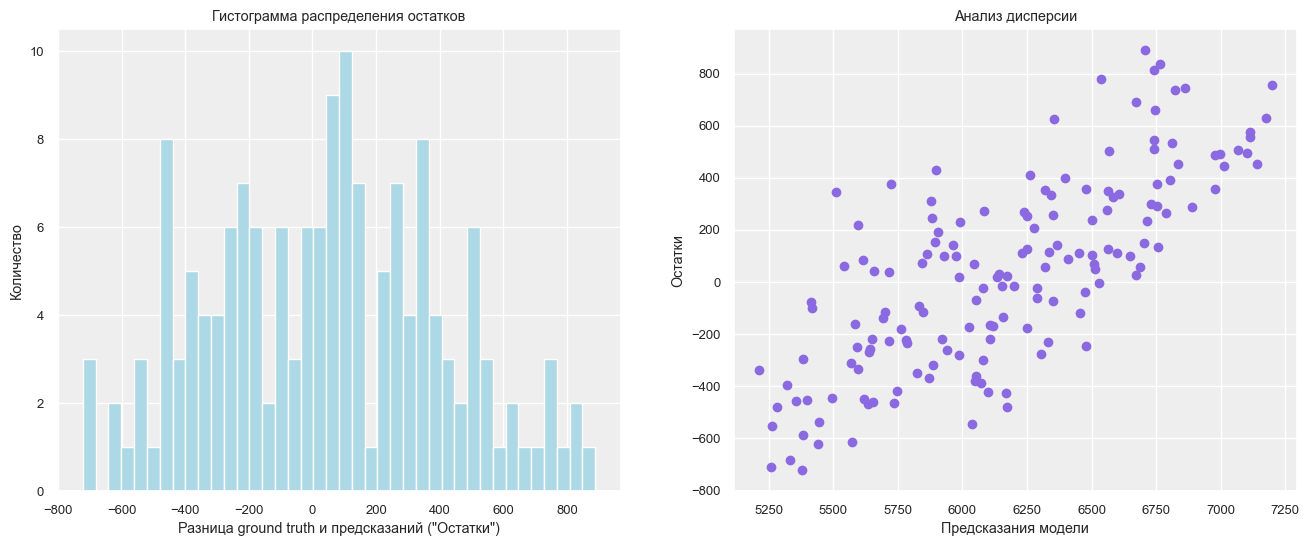

In [91]:
residuals = y_test - predictions
print(color.BOLD+'⇓ Стат. данные по остаткам ⇓')
display(residuals.describe())

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].hist(residuals, bins=40, color='LightBlue')
axs[0].set_facecolor("#eeeeee")
axs[0].set_title('Гистограмма распределения остатков')
axs[0].set_xlabel('Разница ground truth и предсказаний (\"Остатки\")')
axs[0].set_ylabel('Количество')

axs[1].scatter(y=residuals, x=y_test, color='#8b69e1')
axs[1].set_facecolor("#eeeeee")
axs[1].set_title('Анализ дисперсии')
axs[1].set_ylabel('Остатки')
axs[1].set_xlabel('Предсказания модели')
plt.show()

>Как и в случае первой модели, вторая модель ошибается в плюс, выдавая значения меньше реальных. Дисперсия также непостоянна

### Выводы по моделям линейной регрессии

#### Результаты первой версии проекта

В соответствии с ТЗ рассчитаем метрики качества моделей Mean Squared Error и Mean Absolute Error (эти дополнения уже введены в код выше).<br><br>
Заметим, что по ТЗ предполагалось введение "нового" признака - имени папы быка - уже после обсчёта первых двух моделей, но мы скомбинировали исходные датафреймы сразу на этапе предобработки данных (что выглядело логичнее), и учёт этого показателя у нас происходил в рамках корректировки модели № 1.

|Метрика|Модель № 1|Модель № 2|
|---|---|---|
|r2|0.595|-0.034|
|RMSE|317.6|507.5|
|MSE|100842.4|257566.9|
|MAE|260.1|423.0|


Модель № 1 показала лучшие результаты, но "лучшие" они лишь относительно провальных итогов модели № 2, и пользоваться её предсказаниями, строго говоря, не стоит - цифровой показатель r2 здесь означает, что только в 60% случаев предсказание модели ближе к истинному значению, чем среднее истинных значений.

#### Результаты второй версии


|Метрика|Модель-ТЗ № 1|Модель-ТЗ № 2|Модель-ТЗ № 1.1*|Модель-ТЗ № 2.1**|
|---|---|---|---|---|
|r2|0.568|0.456|0.551|0.431|
|RMSE|327.9|368.1|334.5|376.5|
|MSE|107551.2|135511.5|111916.2|141750.5|
|MAE|263.9|303.9|273.4|312.1|

<br>
* - модель № 1 плюс входной признак "имя папы" <br>
** - модель № 2 плюс входной признак "имя папы"


<b>Видим, что итоги первой версии проекта применимы и здесь.</b> Первая модель даёт качество лучше последующих 

#### Доверительный интервал прогноза лучшей модели.
<a id='conf_int'></a>

95% доверительный интервал:

In [103]:
confidence_interval = pd.Series(predictions).quantile([0.025, 0.975])
print(confidence_interval)

0.025    5480.423193
0.975    6630.619162
dtype: float64


>То есть 95% предсказаний по удою лежат в интервале от 5480 до 6630 кг.

#### Прогноз удоя с помощью лучшей модели

Первая из главных задач нашего исследования - <u>прогноз удоя</u>. Обученная модель у нас уже есть. Посмотрим на данные по коровам, для которых нам нужен прогноз.

In [107]:
display(data_f_full[:5])
display(data_cow_buy[:6])

id  удой_кг   эке  сырой_протеин_г    спо             порода тип_пастбища  \
0   1     5863  14.2             1743  0.890     вис_бэк_айдиал    равнинное   
1   2     5529  12.8             2138  0.890     вис_бэк_айдиал    равнинное   
2   3     5810  14.0             1854  0.885  рефлекшн_соверинг    холмистое   
3   4     5895  12.4             2012  0.885  рефлекшн_соверинг    холмистое   
4   5     5302  12.8             1675  0.885     вис_бэк_айдиал    равнинное   

  порода_папы_быка  жирность%  белок%  вкус_молока  возраст  имя_папы  
0           айдиал       3.58   3.076            1        1    буйный  
1          соверин       3.54   3.079            1        0  соловчик  
2          соверин       3.59   3.074            0        1     барин  
3           айдиал       3.40   3.075            0        1    буйный  
4          соверин       3.73   3.073            1        0     барин

порода тип_пастбища порода_папы_быка  имя_папы  \
0     вис_бэк_айдиал    холмистое           айдиал  геркулес   
1     вис_бэк_айдиал    равнинное          соверин    буйный   
2  рефлекшн_соверинг    равнинное          соверин     барин   
3  рефлекшн_соверинг    холмистое           айдиал    буйный   
4  рефлекшн_соверинг    равнинное           айдиал    буйный   
5  рефлекшн_соверинг    равнинное          соверин  геркулес   

   текущая_жирность%  текущий_уровень_белок%  возраст  
0               3.58                   3.076        1  
1               3.54                   3.081        0  
2               3.59                   3.074        1  
3               3.40                   3.061        1  
4               3.64                   3.074        1  
5               3.63                   3.053        0

Для предсказания нам нужны следующие входные признаки (на них обучена лучшая модель № 1):<br>
<code>'эке', 'сырой_протеин_г', 'спо', 'порода', 'тип_пастбища', 'возраст', 'порода_папы_быка'</code><br>

Не хватает данных по первым трём параметрам. По подсказке ТЗ возьмём в качестве этих значений <b>среднее соответствующих параметров</b> в "основном" датафрейме и увеличим на 5%.

In [109]:
# добавили айди, чтобы проще различать коровок, потом уберём
data_cow_buy['id'] = data_cow_buy.index

missed_cats = ['эке', 'сырой_протеин_г', 'спо']

# creating a DF for missing values for yields predictions
#missed_feat = pd.DataFrame(columns=missed_cats, index=range(data_cow_buy.shape[0]), dtype='float32')

# calculating the values as +5% of the mean of corresponding parameters
#missed_feat[missed_cats] = np.round(1.05*data_f_main[missed_cats].mean(), 2)

# trying more clever approach - calculating the mean by the cow breed and pasture type, *1.05 == +5%
missed_feat = data_f_full.groupby(['порода', 'возраст'])[missed_cats].mean().multiply(1.05).reset_index()

# bringing all together
data_to_predict = missed_feat.merge(data_cow_buy.drop(['имя_папы', 'текущая_жирность%', 'текущий_уровень_белок%'], axis=1))

# костыль, чтобы сохранить порядок коров (в файле на покупку), порушенный групировкой и мёржем
#data_to_predict = data_to_predict.sort_values(by='id').reset_index(drop=True).drop('id', axis=1)

data_to_predict = data_to_predict.sort_values(by='id').reset_index(drop=True).drop('id', axis=1)

<b>N.B.</b> Первоначальное решение - заполнить каждую колонку параметров корма (<code>'эке', 'сырой_протеин_г', 'спо'</code>) соответствующим одним и тем же средним, увеличенным на 5% - оказалось не самым удачным. Константные значения при дальнейшей обработке превращаются в нули, и получается, что соответствующие <b>входные признаки "выключаются" из решения</b>, снижая точность.<br><br>
Мы применили более умный подход - взяли не просто среднее значение, а <b>среднее в разрезе типа породы</b> (т. е. получили разные значения среднего для пород Вис бэк айдиал и Рефлекшн соверинг, см. таблицу ниже). Это не только чисто математический трюк, можно найти и реальное логическое объяснение - разным породам коров могут давать разные корма.<br>
В конечном варианте мы добавили ещё и подсчёт среднего <u>в зависимости от возраста</u>, чтобы более точно дифференцировать параметры корма (можно добавить тип пастбища, можно и все три вместе). Ниже приводится таблица с вычисленными средними значениями <code>'эке', 'сырой_протеин_г', 'спо'</code> в зависимости от породы и возраста.

In [111]:
display(missed_feat)

порода  возраст        эке  сырой_протеин_г       спо
0     вис_бэк_айдиал        0  13.593124      1903.620833  0.919042
1     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122
2  рефлекшн_соверинг        0  13.702499      1891.713158  0.916816
3  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010

Мы объединили имеющиеся параметры по коровам с недостающими данными по кормам в датафрейм <b>data_to_predict</b> (проверили отдельно, что операция <code>merge</code> прошла без ошибок). Всё необходимое теперь есть.<br>
Обработаем данные для совершения прогноза ровно теми же инструментами, что были использованы для обучения модели. Для прогноза не нужно разбивать показатели на тренировочную и тестовую части, модель уже обучена.

In [113]:
# categorical columns
cat_names = ['порода', 'тип_пастбища', 'возраст', 'порода_папы_быка']

data_to_predict_encoded = cat_encoder.transform(data_to_predict[cat_names])
data_to_predict_encoded_df = pd.DataFrame(data_to_predict_encoded, columns=cat_encoder.get_feature_names_out())

# scaling the data

names = data_to_predict.columns
num_names = [n for n in names if n not in cat_names]

data_to_predict_scaled = scaler.transform(data_to_predict[num_names])
data_to_predict_scaled_df = pd.DataFrame(data_to_predict_scaled, columns=num_names)

# combining processed data to a single "readable" DF, fitted for feeding our model
data_predict_ready = data_to_predict_scaled_df.join(data_to_predict_encoded_df)

Выведем три строки готовых данных, собранных в единый "читаемый" датафрейм (сделали человекопонятную таблицу с заголовками, а не просто массив цифр).

In [115]:
display(data_predict_ready[:3])

эке  сырой_протеин_г       спо  порода_рефлекшн_соверинг  \
0  0.791281         0.646866  1.651353                       0.0   
1 -0.702781        -0.124852  0.207030                       0.0   
2  0.938623         0.635821  1.739943                       1.0   

   тип_пастбища_холмистое  возраст_1  порода_папы_быка_соверин  
0                     1.0        1.0                       0.0  
1                     0.0        0.0                       1.0  
2                     0.0        1.0                       1.0

Передадим данные нашей модели, заберём у неё прогноз и добавим его для удобства в таблицу с данными животных для покупки.

#### Файл фермера с коровами на покупку с добавлением прогноза по удою

Получим предсказания, запишем в отдельный столбец...

In [119]:
data_to_predict['прогноз_удой_кг'] = model_lr.predict(data_predict_ready)

...и добавим данные, которые пригодятся нам в дальнейшем для прогноза по вкусу

In [121]:
data_to_predict = data_to_predict.join(data_cow_buy[['имя_папы', 'текущая_жирность%', 'текущий_уровень_белок%']])

#### Выбор подходящих кандидаток по удою

Хорошо бы отобрать таких коров, которые точно выйдут за нижнюю границу по удою, обозначенную в ТЗ, то есть для которых даже в случае <a href='#conf_int'>близкой к максимальному ошибки</a> модели удой превысит 6000: 6000 + 864 (для 95% ошибок модели). Но таковых значений у нас не имеется.

<i>С другой стороны</i>, можно сориентироваться на метрику RMSE, по которой наша модель в среднем ошибается примерно на 328 кг, и выбрать значения больше 6000 + 328 (таковых наберётся 7). Так и поступим*, выделив отдельный датафрейм для избранных коровок.

\* <i>В ходе дальнейшего исследования мы получили 0 (ноль) коров со вкусным молоком, подходящих под изменённый порог принадлежности к классам. Поэтому в коде ниже мы опускаем условие по удою и забираем все данные; выбор будем делать на поздних этапах</i>

In [126]:
# chosen_ones_yield - DF with the cows, chosen by milk yield prediction
#chosen_ones_yield = data_to_predict.query('прогноз_удой_кг > 6328')
chosen_ones_yield = data_to_predict.query('прогноз_удой_кг > 0')

## Обучение модели логистической регрессии

Данные у нас уже подготовлены, можно использовать. Только на этот раз целевым показателем будет служить параметр <code>вкус_молока</code>.

#### Предобработка данных для обучения модели

Суть предобработки ровно та же, что и в линейной регресии: необходимо преобразовать все имеющиеся данные "в цифры" и нормировать эти цифры, привести их в единый масштаб.<br>
По <a href='#correlation'>корреляционному анализу</a>, выполненному ранее, следует, что среди доступных нам параметров для вкуса есть лишь слабая связь c характеристиками корма. <del> Попробуем обучить модель на всех имеющихся показателях (совершенно точно нам не нужен только <code>id</code>), а дальше будем экспериментировать.<br>
На этот раз мы немного усложним код и автоматизируем подбор входных признаков для обучения и подсчёт метрик качества, всё это организуем в цикле. Результаты экспериментов будем записывать в датафрейм <code>exp_results</code> </del>

Во второй версии проекта удалим только признаки <code>id, удой_кг</code>

In [132]:
# a DF to record our results
exp_results = pd.DataFrame(index=['accuracy', 'recall', 'precision'], dtype='float32')

In [133]:
# this time we define SETS of features that are not feeding to the model
# and spinning it through the model learning in cycle
# so there's an automation challenge, are we data scientists with Python knowledge or what?

del_fea1 = [['id'],
           ['id', 'имя_папы'],
           ['id', 'порода_папы_быка'],
           ['id', 'имя_папы', 'порода_папы_быка'],
           ['id', 'имя_папы', 'порода_папы_быка', 'удой_кг'],
           ['id', 'порода_папы_быка', 'удой_кг'],
           ['id', 'имя_папы', 'удой_кг'],
           ['id', 'удой_кг'],
           ['id', 'спо'],
           ['id', 'имя_папы', 'спо'],
           ['id', 'имя_папы', 'порода_папы_быка', 'спо'],
           ['id', 'спо', 'удой_кг'],
           ['id', 'спо', 'удой_кг', 'эке'],
           ['id', 'имя_папы', 'порода_папы_быка', 'эке'],
           ['сырой_протеин_г'],
           ['id', 'имя_папы'],
           ['id', 'порода_папы_быка'],
           ['id', 'имя_папы', 'порода_папы_быка', 'сырой_протеин_г', 'спо', 'эке'],           
           ['id', 'порода_папы_быка', 'сырой_протеин_г', 'спо'],
           ['id', 'имя_папы', 'сырой_протеин_г', 'спо'],
           ['id', 'сырой_протеин_г', 'спо'],
           ['id', 'сырой_протеин_г', 'спо', 'эке'],
           ['id', 'имя_папы', 'порода_папы_быка', 'сырой_протеин_г', 'спо']
        ]

# PROJECT 2.0, no experiments, just 1 set of features to drop
del_fea = [['id','удой_кг']]

for feat_set_num in range(0, len(del_fea)):   
    
    # which features to exclude from the learning process?
    learning_data = data_f_full.drop(del_fea[feat_set_num][:], axis=1)
    
    # STANDARD SPLITTING INTO INPUT DATA "X" AND OUTPUT RESULTS "y"

    # let's put features in X
    X = learning_data.drop('вкус_молока', axis=1)

    # let's put targets in y
    y = learning_data['вкус_молока']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE)
    
    # PREPROCESSING: we convert categorical data to numbers
    
    cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

    # all the categories
    all_cat_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
    # but some categories have been excluded from learning, let's drop them 
    cat_names = [n for n in all_cat_names if n not in del_fea[feat_set_num][:]]
    
    # debugging info
    #display(del_fea[feat_set_num][:])
    #display(cat_names)

    X_train_encoded = cat_encoder.fit_transform(X_train[cat_names])
    X_test_encoded = cat_encoder.transform(X_test[cat_names])

    cat_df_train = pd.DataFrame(X_train_encoded, columns=cat_encoder.get_feature_names_out())
    cat_df_test = pd.DataFrame(X_test_encoded, columns=cat_encoder.get_feature_names_out())

    # PREPROCESSING: DATA SCALING
    
    scaler = StandardScaler()

    names = X_train.columns
    num_names = [n for n in names if n not in cat_names]

    X_train_scaled = scaler.fit_transform(X_train[num_names])
    X_test_scaled = scaler.transform(X_test[num_names])
    scaled_df_train = pd.DataFrame(X_train_scaled, columns=num_names)
    scaled_df_test = pd.DataFrame(X_test_scaled, columns=num_names)

    X_train_ready = scaled_df_train.join(cat_df_train)
    X_test_ready = scaled_df_test.join(cat_df_train)
    
    # MODEL TRAINING AND CALCULATING QUALITY METRICS
    
    model_logistic = LogisticRegression()
    model_logistic = model_logistic.fit(X_train_ready, y_train)
    predictions = model_logistic.predict(X_test_ready)
    
    acc = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)

    # let's record all the metrics for this experiment

    exp_results['Эксперимент №'+str(feat_set_num)] = acc, recall, precision

#### Результаты экспериментов

Выведем записи из полученного датафрейма с метриками и автоматически определим максимальные значения метрик, и в каких экспериментах они были получены. Также нарисуем тепловую карту для большей наглядности.<br>
<b>NB</b> Во второй версии проекта у нас ровно 1 эксперимент: оставили максимальный набор фич, удалили только айди и показатель удоя. Хуже по метрикам, но нужно для прохождения квеста

In [136]:
display(exp_results)
for f in range(0, exp_results.shape[0]):
    max_metric = exp_results.loc[exp_results.index[f], :].max()  # maximum of a f-th metric (max of f-th line in our case)
    num_cols_max = np.where(exp_results.iloc[f, :] == max_metric) # numbers of columns of DF where that maximum lies
    names_cols_max = exp_results.columns[num_cols_max].to_list() # names of those columns
    print(f'Максимальное значение метрики {exp_results.index[f]} = {max_metric:.4f} получено в {names_cols_max}')

Эксперимент №0
accuracy         0.605096
recall           0.736842
precision        0.654206

Максимальное значение метрики accuracy = 0.6051 получено в ['Эксперимент №0']
Максимальное значение метрики recall = 0.7368 получено в ['Эксперимент №0']
Максимальное значение метрики precision = 0.6542 получено в ['Эксперимент №0']


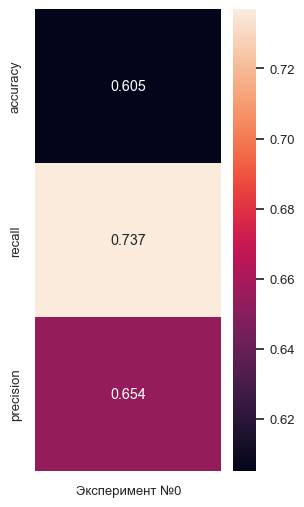

In [137]:
plt.figure(figsize=(exp_results.shape[1]+2, 6))
sns.heatmap(exp_results, annot=True, fmt='.3f');

#### На что мы обращаем внимание в экспериментах?

Мы начнём с того, что выберем результаты с самым высоким показателем Accuracy - это "общая" метрика, оценивающая качество угадывания модели в целом. В разделе ниже мы проведём более тонкую настройку показателей.

Метрики модели второй версии проекта:<br>
<b>Accuracy = 0.605</b><br>
<b>Recall = 0.737</b><br>
<b>Precision = 0.654</b><br><br>


In [140]:
print('Список удалённых параметров при лучшем результате:', del_fea)

Список удалённых параметров при лучшем результате: [['id', 'удой_кг']]


<a id='feat_contrib'></a>

Выведем рассчитанные моделью веса (коэффициенты уравнения). Они показывают вклад каждого входного признака на результат (вкус молока).

In [142]:
for feature_number, feature_name in enumerate(X_train_ready.columns):    
    weights = model_logistic.coef_[0, feature_number]
    print(f"{feature_name:<25}: {weights:+.3f}") 

эке                      : +0.410
сырой_протеин_г          : +0.267
спо                      : +0.170
жирность%                : -0.204
белок%                   : +0.199
порода_рефлекшн_соверинг : -0.215
тип_пастбища_холмистое   : +0.542
порода_папы_быка_соверин : -0.076
возраст_1                : -0.185
имя_папы_буйный          : -0.251
имя_папы_геркулес        : -0.447
имя_папы_соловчик        : -0.467


#### Минимизация критичной ошибки

Как ещё можно улучшить результаты нашей модели?<br><br>
Модель может ошибаться по-разному: предсказывать вкусное молоко (y = 1), а получать по факту невкусное (y = 0), и наоборот.<br>
Если модель ошибётся в "отрицательном" случае (предсказали 0, получили 1) - заказчик всё равно порадует себя вкусным молоком. Хуже, если мы ошибёмся в положительном предсказании модели - если предскажем хороший вкус (y = 1), а фактически он будет никудышным (y = 0). В терминах ML такой результат называется ложно-положительным - False Positive (FP), а к этому результату чувствительна <b>метрика Precision</b> - просто исходя из уравнения метрики, precision = TP/(TP + FP).
<br><u>Таким образом, главной для нас будет метрика Precision</u>.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Все верно! Нужно минимизировать ошибку 1го рода (увеличивать точность модели даже в ущерб полноте). Решение как это сделать вижу ниже - подобрать такой порог, где FP будет равно 0.
</div>

Нарисуем Confusion matrix:

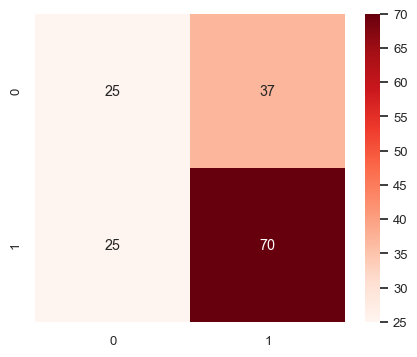

In [147]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds');

Попробуем <b>максимально увеличить</b> выбранную нами как важный показатель <b>метрику Precision</b> (свести к нулю\минимуму количество ошибок False Positive, верхний правый квадрат в матрице). Это можно сделать с помощью изменения порогов принадлежности к классам.<br>
<u>Для манипуляций со случаем False Positive нужно увеличивать порог признания класса истинным</u>

In [149]:
def threshold_cheat(probs):
    if probs > THRESH:
        return(1)
    return(0)

# probabilities generated by our model
y_prob = model_logistic.predict_proba(X_test_ready)

# making a DF with true, pred values and those probabilities
cheat_data = pd.DataFrame(zip(y_test, predictions, y_prob[:, 1]), columns = ['true', 'pred', 'prob'])

#checking if DF is Ok
display(cheat_data[:4])

# cycle for calculating new predictions based on changed thresholds (default thr = 0.5)

print(color.BOLD+color.BLUE+'⇩ Подбираем максимальную метрику Precision ⇩'+color.END)
for thresh_brut in np.linspace(0.1, 1, 10):
    THRESH = thresh_brut
    cheat_data['pred_new'] = cheat_data['prob'].apply(threshold_cheat)
    rec = recall_score(y_test, cheat_data['pred_new'])
    prec = precision_score(y_test, cheat_data['pred_new'])
    print(f'Метрика precision c порогом {color.BOLD}{THRESH:.2f}{color.END} равна {color.BOLD}{prec:.4f}{color.END}')

true  pred      prob
0     1     0  0.402235
1     0     0  0.296656
2     1     1  0.863999
3     1     1  0.820417

⇩ Подбираем максимальную метрику Precision ⇩
Метрика precision c порогом 0.10 равна 0.6051
Метрика precision c порогом 0.20 равна 0.6051
Метрика precision c порогом 0.30 равна 0.6159
Метрика precision c порогом 0.40 равна 0.6159
Метрика precision c порогом 0.50 равна 0.6542
Метрика precision c порогом 0.60 равна 0.6623
Метрика precision c порогом 0.70 равна 0.6591
Метрика precision c порогом 0.80 равна 0.7143
Метрика precision c порогом 0.90 равна 1.0000
Метрика precision c порогом 1.00 равна 0.0000


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>Чтобы получить <b>наивысший Precision = 100%</b>, порог срабатывания модели следует <b>поднять до 0.9</b> (ещё точнее - 0.86, что можно увидеть, если увеличить число разбиений до 20-и).<br>
А как изменятся другие метрики с новым порогом?

In [151]:
THRESH = 0.86
cheat_data['pred_new'] = cheat_data['prob'].apply(threshold_cheat)
rec = recall_score(y_test, cheat_data['pred_new'])
acc = accuracy_score(y_test, cheat_data['pred_new'])
precision = precision_score(y_test, cheat_data['pred_new'])

print(color.BOLD+color.BLUE+'⇩ Изменения в метриках лучшей модели при пороге', THRESH, '⇩'+color.END)
print('Recall =', round(rec - exp_results.loc['recall', :][0], 3))
print('Accuracy =', round(acc - exp_results.loc['accuracy', :][0], 3))
print('Precision =', round(precision - exp_results.loc['precision', :][0], 3))

⇩ Изменения в метриках лучшей модели при пороге 0.86 ⇩
Recall = -0.705
Accuracy = -0.191
Precision = 0.346


C:\Users\Professional\AppData\Local\Temp\ipykernel_11536\737276074.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Recall =', round(rec - exp_results.loc['recall', :][0], 3))
C:\Users\Professional\AppData\Local\Temp\ipykernel_11536\737276074.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Accuracy =', round(acc - exp_results.loc['accuracy', :][0], 3))
C:\Users\Professional\AppData\Local\Temp\ipykernel_11536\737276074.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

Метрика Accuracy в результате наших манипуляций снизилась на 19% - значительно!  Метрика Recall рухнула на 71%.<br>Но ничего - случаи, когда модель ошибётся в "невкусную" сторону, для нас не критичны, а обратные кейсы - когда признает невкусное молоко отличным - мы только что минимизировали.

Посмотрим, как теперь выглядят цифры в Confusion matrix:

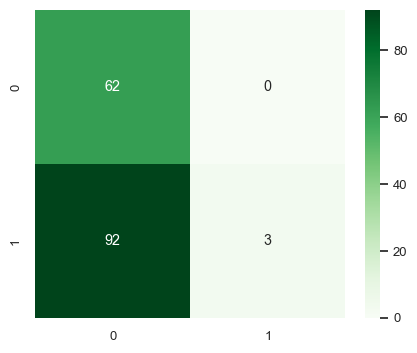

In [154]:
cm = confusion_matrix(y_test, cheat_data['pred_new'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens');

<b>Как использовать подогнанный порог?</b>

Мы подобрали порог классификации, используя тестовые данные. Но как нам учитывать его в реальных предсказаниях? Алгоритм может быть таким: получим результаты от уже обученной модели, заберём из неё значения вероятностей принадлежности к классам и по этим вероятностям точно так же, как мы делали выше, пересчитаем новые предсказания вкуса.

#### Получение предсказания вкуса для коров под покупку

Модель обучена и дополнительно поднастроена; осталось взять коров, отобранных нами по удою, и отправить их данные в предсказатор вкуса.

Только предварительно изменим названия колонок <code>текущая_жирность%, текущий_уровень_белок%</code> - чтобы совпадали с названиями тех колонок, на которых обучился Scaler. Это техническое исправление, связанное с тем, что актуальная версия Scikit-learn обращает внимание на наименование входных признаков, а не только на их порядок

In [160]:
chosen_ones_yield = chosen_ones_yield.rename(columns={'текущая_жирность%':'жирность%', 'текущий_уровень_белок%':'белок%'})

In [161]:
# PREPROCESSING: we convert categorical data to numbers
chosen_ones_yield = chosen_ones_yield.drop(['прогноз_удой_кг'], axis=1)

#cat_encoder = OneHotEncoder(sparse=False, drop='first')
cat_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'возраст', 'имя_папы']
chosen_ones_encoded = cat_encoder.transform(chosen_ones_yield[cat_names])
chosen_ones_encoded = pd.DataFrame(chosen_ones_encoded, columns=cat_encoder.get_feature_names_out())

# PREPROCESSING: DATA SCALING

#scaler = StandardScaler()
names = chosen_ones_yield.columns
num_names = [n for n in names if n not in cat_names]
chosen_ones_scaled = scaler.transform(chosen_ones_yield[num_names])
chosen_ones_scaled = pd.DataFrame(chosen_ones_scaled, columns=num_names)

chosen_ones_pred_taste = chosen_ones_scaled.join(chosen_ones_encoded)

#DISABLED in Project 2.0
# we had just one type of age so it's gone during encoding, let's restore it
#chosen_ones_pred_taste['возраст'] = 1.0

# features-columns are not in right order, let's move them
#chosen_ones_pred_taste = chosen_ones_pred_taste.iloc[:, [3, 0, 1, 2, 4, 5, 6]]

Посмотрим на формат данных для предсказания и данных, на которых обучена модель. Количество фичей (входящих признаков) должно совпадать, и их порядок должен строго соблюдаться.

In [163]:
print(color.BOLD+color.BLUE+'\n ⇩ Данные для прогноза: ⇩')
display(chosen_ones_pred_taste[:2])
print(color.BOLD+color.BLUE+'\n ⇩ Пример данных для отправки в модель: ⇩')
display(X_train_ready[:2])


 ⇩ Данные для прогноза: ⇩


эке  сырой_протеин_г       спо  жирность%    белок%  \
0  0.791281         0.646866  1.651353  -0.112448  0.123271   
1 -0.702781        -0.124852  0.207030  -0.346021  2.167745   

   порода_рефлекшн_соверинг  тип_пастбища_холмистое  порода_папы_быка_соверин  \
0                       0.0                     1.0                       0.0   
1                       0.0                     0.0                       1.0   

   возраст_1  имя_папы_буйный  имя_папы_геркулес  имя_папы_соловчик  
0        1.0              0.0                1.0                0.0  
1        0.0              1.0                0.0                0.0


 ⇩ Пример данных для отправки в модель: ⇩


эке  сырой_протеин_г       спо  жирность%    белок%  \
0  0.986861        -0.074152  0.849982   0.705058  0.941080   
1  0.297797         2.109710  1.156756   0.705058  0.532126   

   порода_рефлекшн_соверинг  тип_пастбища_холмистое  порода_папы_быка_соверин  \
0                       0.0                     1.0                       1.0   
1                       1.0                     1.0                       1.0   

   возраст_1  имя_папы_буйный  имя_папы_геркулес  имя_папы_соловчик  
0        1.0              0.0                0.0                1.0  
1        1.0              0.0                0.0                1.0

Видим, что всё на местах.

In [165]:
predictions = model_logistic.predict(chosen_ones_pred_taste)
chosen_ones_yield['прогноз_вкуса'] = predictions

chosen_ones_yield = chosen_ones_yield.join(data_to_predict['прогноз_удой_кг'])
display(chosen_ones_yield.sort_values(by='прогноз_удой_кг'))

порода  возраст        эке  сырой_протеин_г       спо  \
1      вис_бэк_айдиал        0  13.593124      1903.620833  0.919042   
17  рефлекшн_соверинг        0  13.702499      1891.713158  0.916816   
5   рефлекшн_соверинг        0  13.702499      1891.713158  0.916816   
13     вис_бэк_айдиал        0  13.593124      1903.620833  0.919042   
9   рефлекшн_соверинг        0  13.702499      1891.713158  0.916816   
7      вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
18     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
16     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
10     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
2   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
14  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
8   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
11  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
0      вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
6      вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
12     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
4   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
19  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
15  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
3   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   

   тип_пастбища порода_папы_быка  имя_папы  жирность%  белок%  прогноз_вкуса  \
1     равнинное          соверин    буйный       3.54   3.081              1   
17    равнинное          соверин  геркулес       3.77   3.053              0   
5     равнинное          соверин  геркулес       3.63   3.053              0   
13    холмистое          соверин     барин       3.42   3.075              1   
9     холмистое           айдиал    буйный       3.40   3.079              1   
7     равнинное          соверин    буйный       3.57   3.079              1   
18    равнинное          соверин    буйный       3.34   3.069              1   
16    холмистое          соверин  соловчик       3.73   3.079              1   
10    холмистое          соверин  соловчик       3.73   3.055              0   
2     равнинное          соверин     барин       3.59   3.074              1   
14    равнинное          соверин     барин       3.59   3.074              1   
8     равнинное          соверин     барин       3.59   3.074              1   
11    равнинное          соверин  геркулес       3.73   3.073              1   
0     холмистое           айдиал  геркулес       3.58   3.076              1   
6     холмистое           айдиал  геркулес       3.58   3.076              1   
12    холмистое           айдиал  геркулес       3.68   3.046              0   
4     равнинное           айдиал    буйный       3.64   3.074              1   
19    равнинное           айдиал    буйный       3.64   3.074              1   
15    холмистое           айдиал    буйный       3.40   3.065              1   
3     холмистое           айдиал    буйный       3.40   3.061              1   

    прогноз_удой_кг  
1       5723.294863  
17      5731.305098  
5       5731.305098  
13      5765.945261  
9       5968.504828  
7       6467.270597  
18      6467.270597  
16      6509.920995  
10      6509.920995  
2       6515.157453  
14      6515.157453  
8       6515.157453  
11      6515.157453  
0       6704.470327  
6       6704.470327  
12      6704.470327  
4       6709.706785  
19      6709.706785  
15      6752.357183  
3       6752.357183

#### Настройка прогнозатора на максимальную вкусность

Изменим порог определения вкусного\невкусного молока на вычисленный ранее (0.86).

In [168]:
THRESH = 0.75
chosen_ones_yield['вероятности'] = model_logistic.predict_proba(chosen_ones_pred_taste)[:, 1]
chosen_ones_yield['уточн_прогноз_вкуса'] = chosen_ones_yield['вероятности'].apply(threshold_cheat)
chosen_ones_yield.sort_values(by='прогноз_удой_кг')

порода  возраст        эке  сырой_протеин_г       спо  \
1      вис_бэк_айдиал        0  13.593124      1903.620833  0.919042   
17  рефлекшн_соверинг        0  13.702499      1891.713158  0.916816   
5   рефлекшн_соверинг        0  13.702499      1891.713158  0.916816   
13     вис_бэк_айдиал        0  13.593124      1903.620833  0.919042   
9   рефлекшн_соверинг        0  13.702499      1891.713158  0.916816   
7      вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
18     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
16     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
10     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
2   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
14  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
8   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
11  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
0      вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
6      вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
12     вис_бэк_айдиал        1  15.544549      2046.383500  0.966122   
4   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
19  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
15  рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   
3   рефлекшн_соверинг        1  15.736995      2044.340367  0.969010   

   тип_пастбища порода_папы_быка  имя_папы  жирность%  белок%  прогноз_вкуса  \
1     равнинное          соверин    буйный       3.54   3.081              1   
17    равнинное          соверин  геркулес       3.77   3.053              0   
5     равнинное          соверин  геркулес       3.63   3.053              0   
13    холмистое          соверин     барин       3.42   3.075              1   
9     холмистое           айдиал    буйный       3.40   3.079              1   
7     равнинное          соверин    буйный       3.57   3.079              1   
18    равнинное          соверин    буйный       3.34   3.069              1   
16    холмистое          соверин  соловчик       3.73   3.079              1   
10    холмистое          соверин  соловчик       3.73   3.055              0   
2     равнинное          соверин     барин       3.59   3.074              1   
14    равнинное          соверин     барин       3.59   3.074              1   
8     равнинное          соверин     барин       3.59   3.074              1   
11    равнинное          соверин  геркулес       3.73   3.073              1   
0     холмистое           айдиал  геркулес       3.58   3.076              1   
6     холмистое           айдиал  геркулес       3.58   3.076              1   
12    холмистое           айдиал  геркулес       3.68   3.046              0   
4     равнинное           айдиал    буйный       3.64   3.074              1   
19    равнинное           айдиал    буйный       3.64   3.074              1   
15    холмистое           айдиал    буйный       3.40   3.065              1   
3     холмистое           айдиал    буйный       3.40   3.061              1   

    прогноз_удой_кг  вероятности  уточн_прогноз_вкуса  
1       5723.294863     0.610815                    0  
17      5731.305098     0.075457                    0  
5       5731.305098     0.087963                    0  
13      5765.945261     0.710686                    0  
9       5968.504828     0.703198                    0  
7       6467.270597     0.755982                    1  
18      6467.270597     0.643824                    0  
16      6509.920995     0.780077                    1  
10      6509.920995     0.335077                    0  
2       6515.157453     0.691792                    0  
14      6515.157453     0.691792                    0  
8       6515.157453     0.691792                    0  
11      6515.157453     0.528368                    0  
0       6704.470327     0.785284     

Но не всё так просто, как мы <i>продолжаем</i> постоянно убеждаться в этом проекте. Оказывается, выбранный ранее порог слишком высокий и <b>все</b> данные коров на покупку показывают отрицательный результат в плане вкуса молока.<br>
Что здесь можно сделать? Остаётся только делать выбор с наивысшими имеющимися вероятностями, т. е. снизить порог примерно до 0.75.<br>
<i>В коде выше мы это уже сделали, поэтому в колонке <code>уточн_прогноз_вкуса</code> есть не только нули, но и единицы.</i><br><br>
Тогда подходящими станут следующие коровы: №№ 7, 16, 0, 6 (нумерация совпадает с исходным файлом с коровами на покупку от фермера).

## Итоговые выводы

#### Выбор коров по удою и вкусу для покупки

Каких же коров фермер может купить с наименьшими рисками для себя?<br>
Это коровы под номерами №№ 7, 16, 0, 6. Выведем данные по ним в таблице.

In [173]:
display(chosen_ones_yield.query('вероятности > 0.75').sort_values(by='прогноз_удой_кг'))

порода  возраст        эке  сырой_протеин_г       спо  \
7   вис_бэк_айдиал        1  15.544549        2046.3835  0.966122   
16  вис_бэк_айдиал        1  15.544549        2046.3835  0.966122   
0   вис_бэк_айдиал        1  15.544549        2046.3835  0.966122   
6   вис_бэк_айдиал        1  15.544549        2046.3835  0.966122   

   тип_пастбища порода_папы_быка  имя_папы  жирность%  белок%  прогноз_вкуса  \
7     равнинное          соверин    буйный       3.57   3.079              1   
16    холмистое          соверин  соловчик       3.73   3.079              1   
0     холмистое           айдиал  геркулес       3.58   3.076              1   
6     холмистое           айдиал  геркулес       3.58   3.076              1   

    прогноз_удой_кг  вероятности  уточн_прогноз_вкуса  
7       6467.270597     0.755982                    1  
16      6509.920995     0.780077                    1  
0       6704.470327     0.785284                    1  
6       6704.470327     0.785284                    1

Отметим, что есть большая вероятность, что коровы под номерами 0 и 6 - это одна корова, данные которой задублировались.

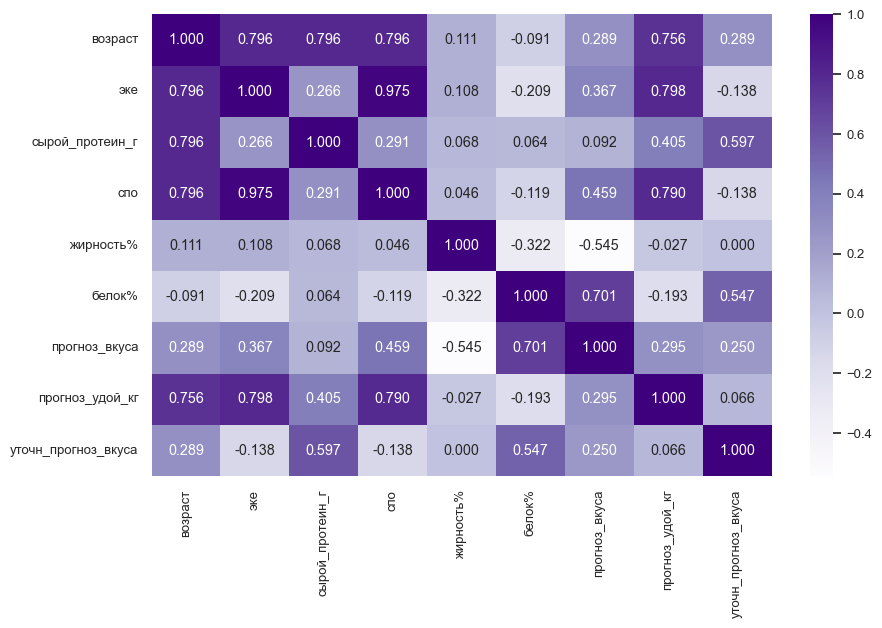

In [175]:
plt.figure(figsize=(10, 6))
sns.heatmap(chosen_ones_yield.drop(['вероятности'], axis=1).corr(method='spearman', numeric_only=True), cmap='Purples', annot=True, fmt='.3f');

#### Советы по выбору, версия Проекта № 2

Во втором варианте проекта подтверждено следующее:
- удой больше всего зависит от возраста коров (в нашем случае выбирать надо коров старше года) и параметров корма;
- удой в среднем выше у потомков быков породы Айдиал;
- вкус тем лучше, чем больше уровень белка (высокая прямо пропорциональная зависимость), и ухудшается при высокой жирности (умеренная обратная зависимость)
- высокое соответствие между вкусом молока и конкретной породой не подтвердилось
<br>

В целом, на месте пейзанина-заказчика, я бы не очень доверял результатам с теми метриками, что мы получили.

#### Что может быть сделано для улучшения моделей?

Мы полагаем, что заказчик имел бюджет на покупку минимум половины (8) из указанных в файле для покупки коров. Результатом нашего проекта, потребовавшего месячного труда, явились рекомендации по покупке пяти животных. Оставшиеся средства рекомендуется направить для дальнейшего изучения проблемы: в частности, сбора необходимых, более точных данных для построения высококачественных моделей машинного обучения.<br><br>
Для модели линейной регрессии мы испробовали практически всё, включая комбинации из фичей, не вошедшие в итоговый проект, так как они не улучшили качество. Возможно, более глубокое изучение связей между параметрами корма и удоя помогло бы, но это лежит сильно за рамками обучения.